In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [2]:
bolTrainagain = False # will try to load data if false 

In [3]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=4
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 3 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  549.2743055555592
Friday area:  454.26388888889045
Weekend area:  244.2499999999996
Weekday maximum:  25.875
Friday maximum:  20.833333333333332
Weekend maximum:  11.0


## MATHEMATICAL MODEL - CDF Subtraction

In [4]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_areanormalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_areanormalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_areanormalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})
if not(bolTrainagain):
    try:
        with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
            [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                 errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
            f.close()
    except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
        print('no saved data: recalcualting')
        bolTrainagain = True

if bolTrainagain:

    errors_wd = np.ones(np.shape(training_weekdays_norm))
    optimal_params_weekdaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_weekdays_norm, errors_wd),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 10000})


In [5]:
var_weekdaytn = np.mean(errors_wd)
stdv_weekdaytn=math.sqrt(var_weekdaytn)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors_wd,0))
#print('stdv per time-step')
#for i in stdv_weekday30mins:
#    print('\t' + str(i))

global stdv 0.00659



In [6]:
optimal_params_weekdaytn

 final_simplex: (array([[0.29906572, 0.05478201, 0.8978877 , 0.24004392],
       [0.29906575, 0.05478207, 0.89788736, 0.24004371],
       [0.29906577, 0.05478213, 0.89788819, 0.24004456],
       [0.29906576, 0.05478211, 0.89788762, 0.24004422],
       [0.29906573, 0.05478218, 0.89788773, 0.24004415]]), array([0.05007819, 0.05007819, 0.05007819, 0.05007819, 0.05007819]))
           fun: 0.05007818991826081
       message: 'Optimization terminated successfully.'
          nfev: 273
           nit: 159
        status: 0
       success: True
             x: array([0.29906572, 0.05478201, 0.8978877 , 0.24004392])

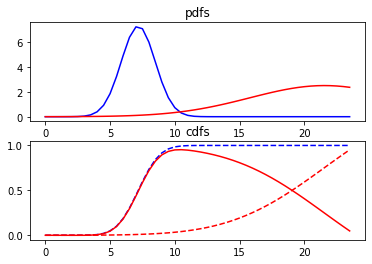

In [7]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [8]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.29906572, 0.05478201, 0.8978877 , 0.24004392])

In [9]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
#plt.plot(time2, cdf2_wd, label="Cummulative probability departure")

#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");


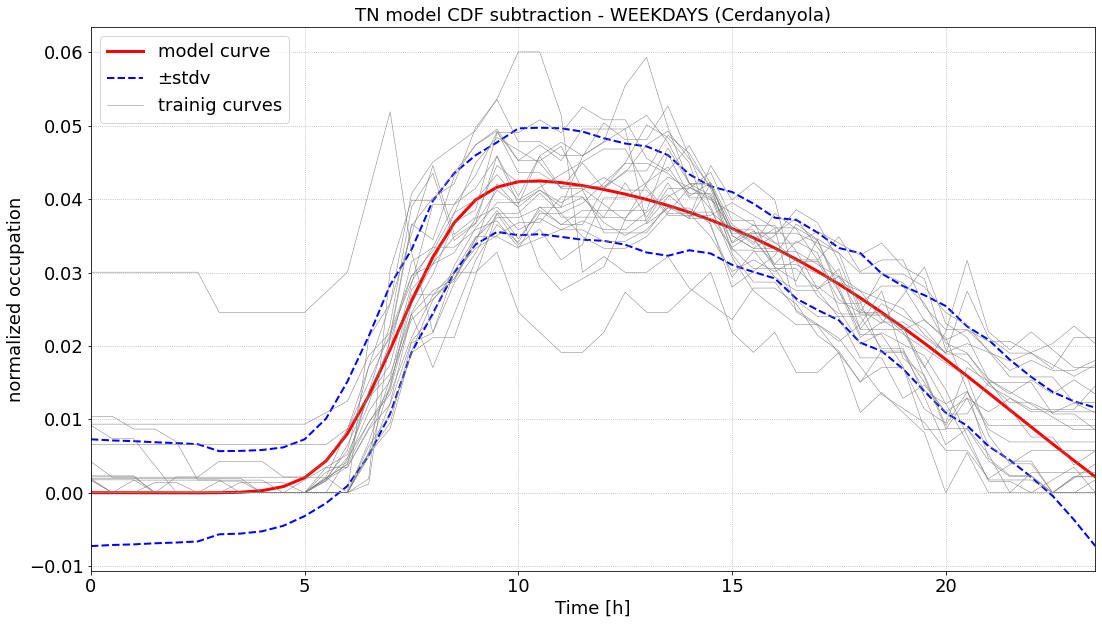

In [10]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekday-stdv_weekday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekday+stdv_weekday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    if i==0:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'.pdf',bbox_inches='tight');
fig.savefig('Training_'+current_parking+'.png',bbox_inches='tight');

### FRIDAYS

In [11]:
parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_fridaytn = minimize(model_tn_areaN, parameters_tn, args=(training_fridays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

if bolTrainagain:
    errors_fr = np.ones(np.shape(training_fridays_norm))
    optimal_params_fridaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_fridays_norm, errors_fr),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True})


In [12]:
var_fridaytn = np.mean(errors_fr)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors_fr,0))
print('stdv per time-step')
#for i in stdv_friday30mins:
#    print('\t' + str(i))

global stdv 0.00993

stdv per time-step


In [13]:
optimal_params_fridaytn

 final_simplex: (array([[0.24453507, 0.14105349, 0.69562037, 0.35231557],
       [0.24453496, 0.14105363, 0.69562044, 0.35231589],
       [0.2445351 , 0.14105357, 0.6956198 , 0.35231614],
       [0.24453505, 0.14105364, 0.6956197 , 0.35231548],
       [0.2445351 , 0.14105366, 0.69561995, 0.35231554]]), array([0.02842283, 0.02842283, 0.02842283, 0.02842283, 0.02842283]))
           fun: 0.028422828585944894
       message: 'Optimization terminated successfully.'
          nfev: 394
           nit: 237
        status: 0
       success: True
             x: array([0.24453507, 0.14105349, 0.69562037, 0.35231557])

In [14]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

In [15]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta/sum(resta)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_fri, label="CDF Slot occupied")
#plt.plot(time, cdf2_fri, label="CDF Slot free")
#plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
#plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

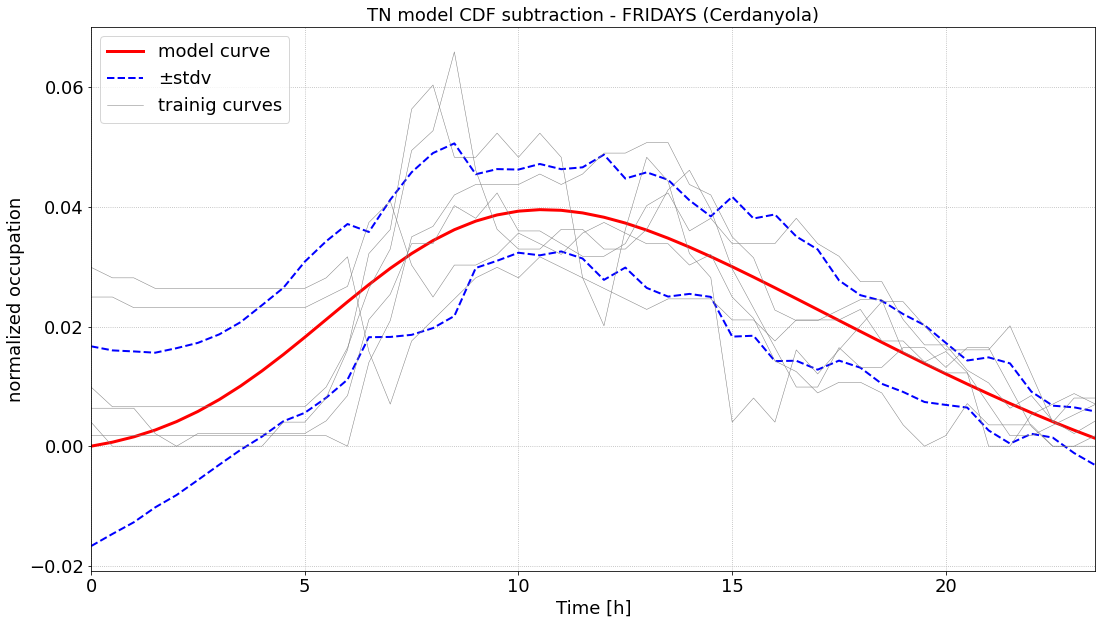

In [16]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_friday-stdv_friday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_friday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_friday+stdv_friday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'_FRIDAY.pdf',bbox_inches='tight');

### WEEKENDS

In [17]:
parameters_tn = np.array([.2 ,.05,.7,.1])
if bolTrainagain:
    errors_we = np.ones(np.shape(training_weekends_norm))    
    if ((current_parking == "SantBoi") or (current_parking == "Cerdanyola")): 
        #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='SLSQP',
        #                                   bounds=((0, None), (0, None),(0, None),(0, None)),
        #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
        optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                        parameters_tn, 
                                        args=(training_weekends_norm, errors_we),
                                        method='SLSQP',
                                        bounds=((0, None), (0, None),(0, None),(0, None)),
                                        tol=1e-6, options={'disp': True, 'maxfev': 100000})
    else:
        #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='Nelder-Mead',
        #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})     

        optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                        parameters_tn, 
                                        args=(training_weekends_norm, errors_we),
                                        method='Nelder-Mead',
                                        tol=1e-6, options={'disp': True, 'maxfev': 100000})
        

## save the model fits

In [18]:
if bolTrainagain:
    #save modelparams and error
    with open('data/'+current_parking+'_modelFit.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we], f)
        f.close()
    
    # Getting back the objects:
    with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()

In [19]:
var_weekendtn = np.mean(errors_we)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors_we,0))
#print('stdv per time-step')
#for i in stdv_weekend30mins:
#    print('\t' + str(i))

global stdv 0.01501



In [20]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([0.35367938, 0.17198693, 0.76784077, 0.30805419])

In [21]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we/sum(resta_we)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_we, label="CDF Slot occupied")
#plt.plot(time, cdf2_we, label="CDF Slot free")
#plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
#plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")



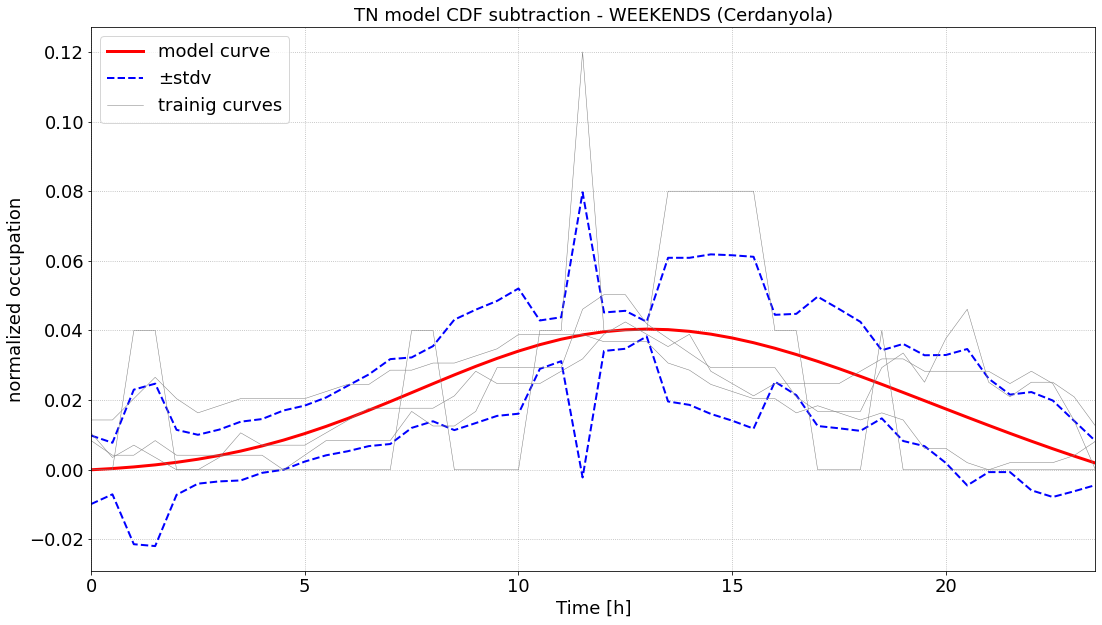

In [22]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekend-stdv_weekend30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekend, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekend+stdv_weekend30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

for i in range(0,len(training_weekends_norm)):
    if i==0:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'WEEKEND.pdf',bbox_inches='tight');

In [23]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

--------- WEEKDAYS Cerdanyola -----------
Mean Arrival Time   = 07:10h
stdv Arrival        =  1:18h
Mean Departure Time = 21:32h
stdv Departure      =  5:45h
--------- FRIDAYS Cerdanyola -----------
Mean Arrival Time   = 05:52h
stdv Arrival        =  3:23h
Mean Departure Time = 16:41h
stdv Departure      =  8:27h
--------- WEEKENDS Cerdanyola -----------
Mean Arrival Time   = 08:29h
stdv Arrival        =  4:07h
Mean Departure Time = 18:25h
stdv Departure      =  7:23h


In [24]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

In [25]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 

### Comparing normalized mathematical fitted prototype with testing data

### Denormalization / Rescaling

In [26]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset
#**************************************WEEKDAY************************************
tn_weekday_nooff = tn_weekday_n*weekday_area
#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset
tn_friday_nooff = tn_friday_n*friday_area 
#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 
tn1_weekend_nooff = tn1_weekend_n*weekend_area

In [27]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

______ MEAN ± STDV________
4.794713690774718  ±  0.0
2.6318436049980334  ±  1.2312516374340234
3.900014068777375  ±  1.8490851622531164
3.6635868857681024  ±  3.5558857239683057
6.013134410184463  ±  6.509528046412455
1.8387440351132367  ±  1.2486357413146099
2.437593285537425  ±  0.7056137463002106


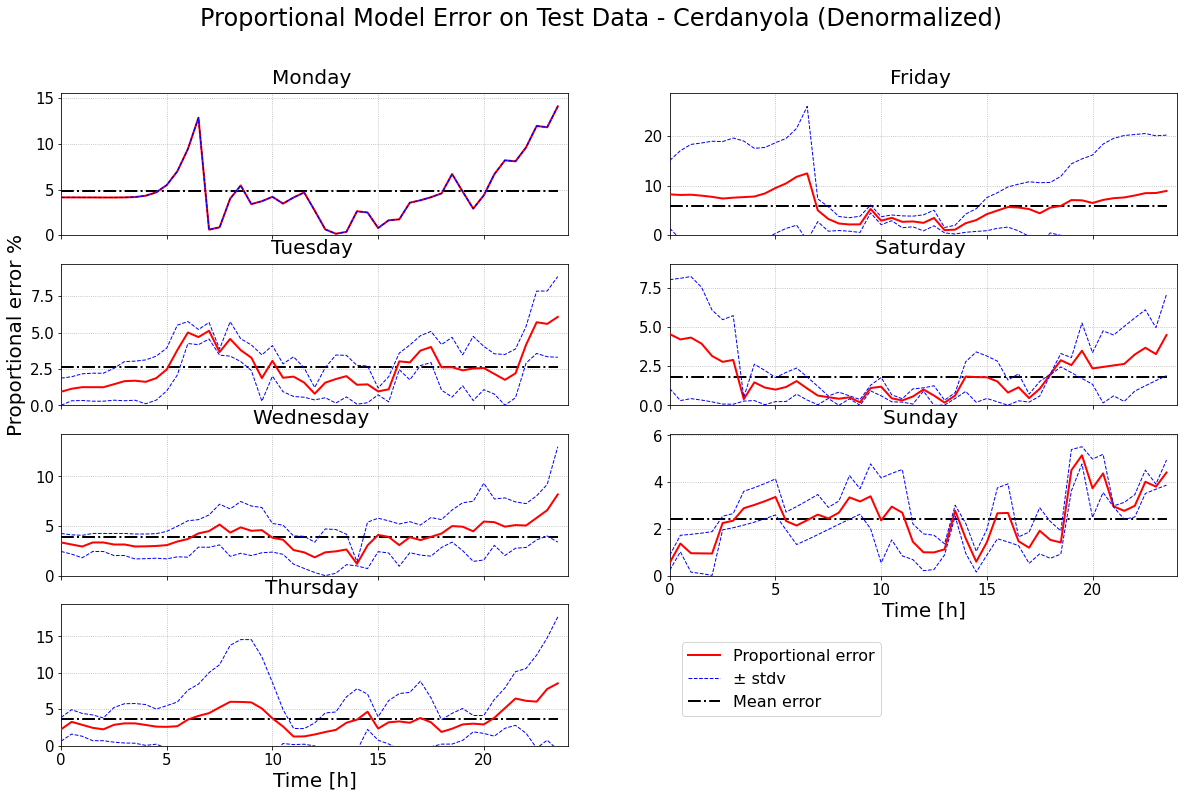

In [28]:
#[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv(testing_mondays, tn_weekday, max_value)
[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv_fit(testing_mondays, tn_weekday, max_value)
[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv_fit(testing_tuesdays, tn_weekday, max_value)
[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv_fit(testing_wednesdays, tn_weekday, max_value)
[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv_fit(testing_thursdays, tn_weekday, max_value)
[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv_fit(testing_fridays, tn_friday, max_value)
[error_saturday_tn,stdv_error_saturday_tn] = compute_testing_prop_errorMstdv_fit(testing_saturdays, tn1_weekend, max_value)
[error_sunday_tn,stdv_error_sunday_tn] = compute_testing_prop_errorMstdv_fit(testing_sundays, tn1_weekend, max_value)


fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
mstdv_Monday= np.mean(stdv_error_monday_tn[~np.isnan(stdv_error_monday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_tn, stdv_error_monday_tn, mean_Monday, 
                 'Monday ', 'Monday',False,False,False,False)

mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
mstdv_Tuesday= np.mean(stdv_error_tuesday_tn[~np.isnan(stdv_error_tuesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_tn, stdv_error_tuesday_tn,  mean_Tuesday, 
                 'Tuesday ', 'Tuesday',False,True,False,False)

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
mstdv_Wednesday= np.mean(stdv_error_wednesday_tn[~np.isnan(stdv_error_wednesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_tn, stdv_error_wednesday_tn, mean_Wednesday, 
                 'Wednesday ', 'Wednesday',False,False,False,False)

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
mstdv_Thursday= np.mean(stdv_error_thursday_tn[~np.isnan(stdv_error_thursday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_tn, stdv_error_thursday_tn, mean_Thursday, 
                 'Thursday ', 'Thursday',True,False,True,False)

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
mstdv_Friday= np.mean(stdv_error_friday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_tn, stdv_error_friday_tn, mean_Friday, 
                 'Friday ', 'Friday',False,False,False,False)

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
mstdv_Saturday= np.mean(stdv_error_saturday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_tn, stdv_error_saturday_tn, mean_Saturday, 
                 'Saturday ', 'Saturday',False,False,False,False)

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
mstdv_Sunday= np.mean(stdv_error_sunday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_tn, stdv_error_sunday_tn, mean_Sunday, 
                 'Sunday ', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
fig.savefig('TestError_'+current_parking+'.pdf',bbox_inches='tight');
#ax[2,2].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print( mean_Monday[0], ' ± ', mstdv_Monday)
print(mean_Tuesday[0], ' ± ', mstdv_Tuesday)
print(mean_Wednesday[0], ' ± ', mstdv_Wednesday)
print(mean_Thursday[0], ' ± ', mstdv_Thursday)
print(mean_Friday[0], ' ± ', mstdv_Friday)
print(mean_Saturday[0], ' ± ', mstdv_Saturday)
print(mean_Sunday[0], ' ± ', mstdv_Sunday)
#print('______STDV________')

#print(np.std(error_monday_tn))
#print(np.std(error_tuesday_tn))
#print(np.std(error_wednesday_tn))
#print(np.std(error_thursday_tn))
#print(np.std(error_friday_tn))
#print(np.std(error_saturday_tn))
#print(np.std(error_sunday_tn))



In [29]:
m_row=[current_parking,'meanE',mean_Monday[0], mean_Tuesday[0], mean_Wednesday[0], mean_Thursday[0],
       mean_Friday[0],mean_Saturday[0], mean_Sunday[0]]
s_row=[current_parking,'mStdvE',mstdv_Monday, mstdv_Tuesday, mstdv_Wednesday,  mstdv_Thursday, 
       mstdv_Friday, mstdv_Saturday, mstdv_Sunday]

In [30]:
f = open('data/'+current_parking+'_testError.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row)
writer.writerow(s_row)

# close the file
f.close()

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [31]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

______ MEAN ± STDV________
4.710934183734473  ±  0.0
2.4657549261240868  ±  1.2200849416018464
3.8675282764926258  ±  1.7446061419153995
3.467586286517246  ±  3.38390901856844
5.762868588901429  ±  7.017958426698399
1.988693372105464  ±  1.2892156575583067
2.6176206554744383  ±  0.8136997666291967


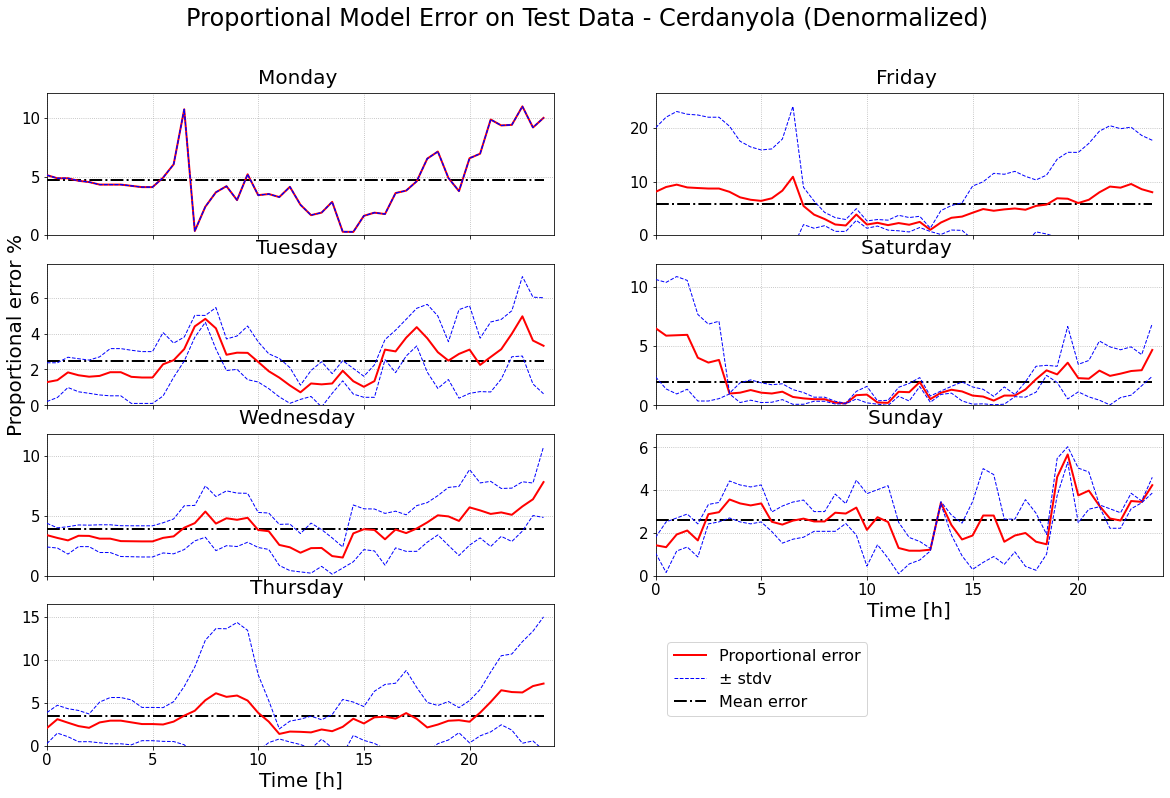

In [32]:
#[error_monday_proto,stdv_error_monday_proto] = compute_testing_prop_errorMstdv(testing_mondays, tn_weekday, max_value)
[error_monday_proto,stdv_error_monday_proto] = compute_testing_prop_errorMstdv_fit(testing_mondays, hist_weekday_proto.values, max_value)
[error_tuesday_proto,stdv_error_tuesday_proto] = compute_testing_prop_errorMstdv_fit(testing_tuesdays, hist_weekday_proto.values, max_value)
[error_wednesday_proto,stdv_error_wednesday_proto] = compute_testing_prop_errorMstdv_fit(testing_wednesdays, hist_weekday_proto.values, max_value)
[error_thursday_proto,stdv_error_thursday_proto] = compute_testing_prop_errorMstdv_fit(testing_thursdays, hist_weekday_proto.values, max_value)
[error_friday_proto,stdv_error_friday_proto] = compute_testing_prop_errorMstdv_fit(testing_fridays, hist_friday_proto.values, max_value)
[error_saturday_proto,stdv_error_saturday_proto] = compute_testing_prop_errorMstdv_fit(testing_saturdays, hist_weekend_proto.values, max_value)
[error_sunday_proto,stdv_error_sunday_proto] = compute_testing_prop_errorMstdv_fit(testing_sundays, hist_weekend_proto.values, max_value)


fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday_proto =  [np.mean(error_monday_proto)]*len(time)
mstdv_Monday_proto= np.mean(stdv_error_monday_proto[~np.isnan(stdv_error_monday_proto)])
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_proto, stdv_error_monday_proto, mean_Monday_proto, 
                 'Monday ', 'Monday',False,False,False,False)

mean_Tuesday_proto =  [np.mean(error_tuesday_proto)]*len(time)
mstdv_Tuesday_proto= np.mean(stdv_error_tuesday_proto[~np.isnan(stdv_error_tuesday_proto)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_proto, stdv_error_tuesday_proto,  mean_Tuesday_proto, 
                 'Tuesday ', 'Tuesday',False,True,False,False)

mean_Wednesday_proto =  [np.mean(error_wednesday_proto)]*len(time)
mstdv_Wednesday_proto= np.mean(stdv_error_wednesday_proto[~np.isnan(stdv_error_wednesday_proto)])
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_proto, stdv_error_wednesday_proto, mean_Wednesday_proto, 
                 'Wednesday ', 'Wednesday',False,False,False,False)

mean_Thursday_proto =  [np.mean(error_thursday_proto)]*len(time)
mstdv_Thursday_proto= np.mean(stdv_error_thursday_proto[~np.isnan(stdv_error_thursday_proto)])
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_proto, stdv_error_thursday_proto, mean_Thursday_proto, 
                 'Thursday ', 'Thursday',True,False,True,False)

mean_Friday_proto =  [np.mean(error_friday_proto)]*len(time)
mstdv_Friday_proto= np.mean(stdv_error_friday_proto)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_proto, stdv_error_friday_proto, mean_Friday_proto, 
                 'Friday ', 'Friday',False,False,False,False)

mean_Saturday_proto =  [np.mean(error_saturday_proto)]*len(time)
mstdv_Saturday_proto= np.mean(stdv_error_saturday_proto)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_proto, stdv_error_saturday_proto, mean_Saturday_proto, 
                 'Saturday ', 'Saturday',False,False,False,False)

mean_Sunday_proto =  [np.mean(error_sunday_proto)]*len(time)
mstdv_Sunday_proto = np.mean(stdv_error_sunday_proto)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_proto, stdv_error_sunday_proto, mean_Sunday_proto, 
                 'Sunday ', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
#fig.savefig('TestError_'+current_parking+'_proto.pdf',bbox_inches='tight');
#ax[2,2].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print(mean_Monday_proto[0], ' ± ', mstdv_Monday_proto)
print(mean_Tuesday_proto[0], ' ± ', mstdv_Tuesday_proto)
print(mean_Wednesday_proto[0], ' ± ', mstdv_Wednesday_proto)
print(mean_Thursday_proto[0], ' ± ', mstdv_Thursday_proto)
print(mean_Friday_proto[0], ' ± ', mstdv_Friday_proto)
print(mean_Saturday_proto[0], ' ± ', mstdv_Saturday_proto)
print(mean_Sunday_proto[0], ' ± ', mstdv_Sunday_proto)
#print('______STDV________')





In [33]:
m_row_proto=[current_parking,'meanE_proto',mean_Monday_proto[0], mean_Tuesday_proto[0], mean_Wednesday_proto[0], mean_Thursday_proto[0],
       mean_Friday_proto[0],mean_Saturday_proto[0], mean_Sunday_proto[0]]
s_row_proto=[current_parking,'mStdvE_proto',mstdv_Monday_proto, mstdv_Tuesday_proto, mstdv_Wednesday_proto,  mstdv_Thursday_proto, 
       mstdv_Friday_proto, mstdv_Saturday_proto, mstdv_Sunday_proto]

In [34]:
f = open('data/'+current_parking+'_testError_proto.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row_proto)
writer.writerow(s_row_proto)

# close the file
f.close()

#### MONDAY

In [35]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 14
day = 'Monday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-03-02
Real Monday scaled prototype error:  9.55 %
Real Monday scaled prototype error (median):  9.6 %
Real Monday scaled prototype STDV: 3.7938290856738806
Real Monday scaled TN error:  9.71 %
Real Monday scaled TN error (median):  8.44 %
Real Monday scaled TN STDV:  4.252752469509626
_____________________________________________________________


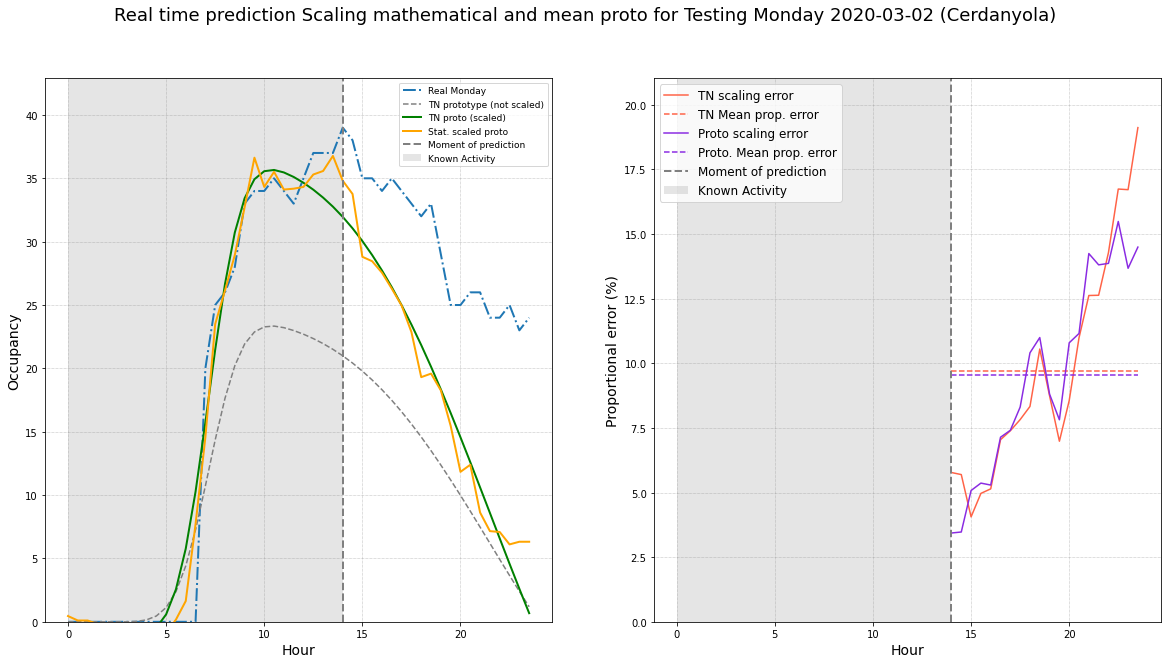

In [36]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

In [37]:
starting_hour=7

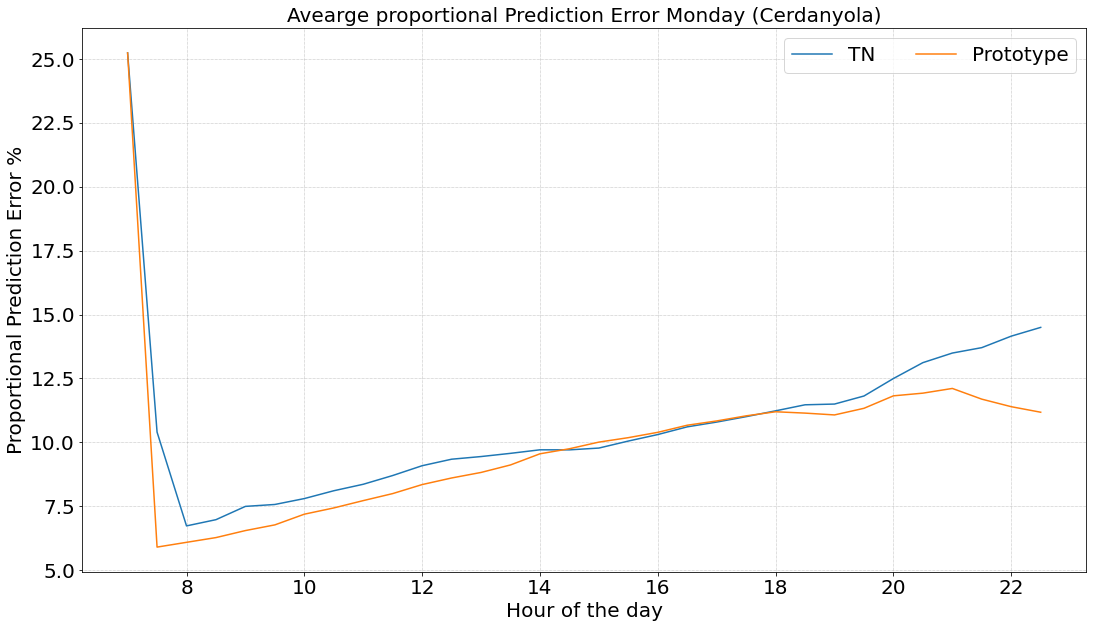

In [38]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [39]:
proto_running_error_wd=proto_running_error_vec
tn_running_error_wd=tn_running_error_vec

2020-03-02
Real Monday scaled prototype error:  3.92 %
Real Monday scaled prototype error (median):  3.78 %
Real Monday scaled prototype STDV: 2.578906291617629
Real Monday scaled TN error:  2.79 %
Real Monday scaled TN error (median):  1.35 %
Real Monday scaled TN STDV:  2.7381628505632456
_____________________________________________________________


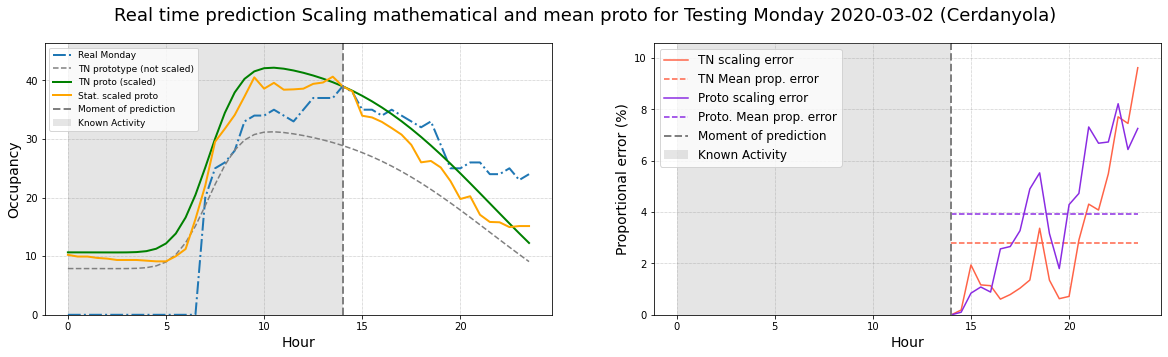

In [40]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

2020-03-02


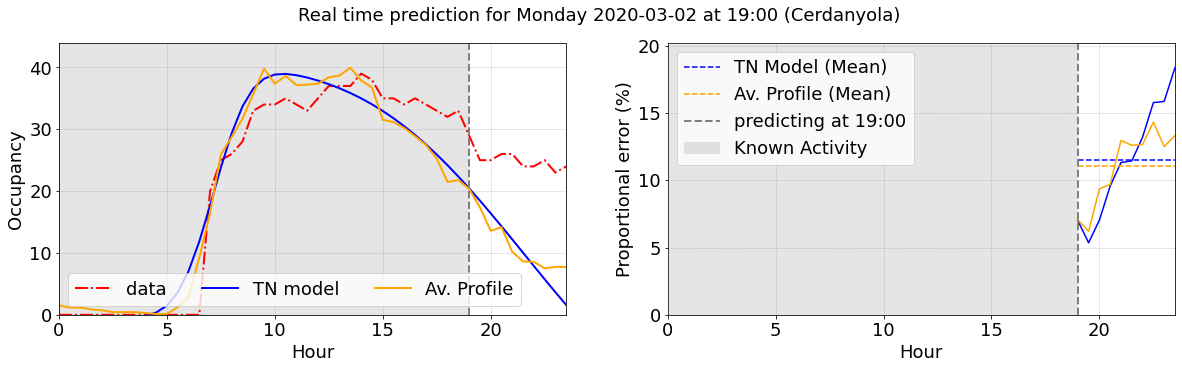

In [41]:
limit_hour = 19
fsize=18


if isinstance(limit_hour, int):
    hourstring = str(limit_hour) + ':00'
else:
    hourstring = str(int(limit_hour))+':'+str(int((limit_hour-int(limit_hour))*60))

cont=0
i=0



t_date=t_dates[cont]
print(t_date)
tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]


#scaled_stat_proto = statistic_proto.values 
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(5)
axx=0;
time = np.linspace(0,23.5,48)
fig.suptitle('Real time prediction for '
             + day + ' ' +t_date + ' at '+ hourstring +' ('+ current_parking+')', fontsize=fsize)
ax[axx].plot(time, t_days[i].values, linestyle='dashdot', color='red', linewidth=2, label='data')

ax[axx].plot(time, scaled_tn_proto, color='blue', linewidth=2 , label='TN model')
ax[axx].plot(time, scaled_stat_proto, color='orange', linewidth=2, label='Av. Profile')
ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2)
ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2)
ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[axx].legend(fontsize=fsize, loc="best",ncol=3)
ax[axx].set_ylim([0,1.1*max([max(t_days[i].values),max(tn_proto),max(scaled_tn_proto),
                             max(scaled_stat_proto)])])
ax[axx].set_xlabel('Hour', fontsize=fsize)
ax[axx].set_xlim([0,23.5])
ax[axx].set_ylabel('Occupancy', fontsize=fsize)
ax[axx].tick_params(axis='x', labelsize=fsize)
ax[axx].tick_params(axis='y', labelsize=fsize)
axx=1;



limit_hourIdx = int(limit_hour*2)
tn_scaled_error = (np.absolute((np.array(scaled_tn_proto) - np.array(t_days[i].values)))/max_value)*100
mean_scaled_error = (np.absolute((np.array(scaled_stat_proto) - np.array(t_days[i].values)))/max_value)*100

#tn_scaled_error = (np.absolute((np.array(scaled_tn_proto) - np.array(t_days[i].values)))/np.array(t_days[i].values))*100
#mean_scaled_error = (np.absolute((np.array(scaled_stat_proto) - np.array(t_days[i].values)))/np.array(t_days[i].values))*100

tn_s_error_mean = [np.mean(tn_scaled_error[limit_hourIdx:])]*len(tn_scaled_error)
mean_s_error_mean = [np.mean(mean_scaled_error[limit_hourIdx:])]*len(mean_scaled_error)

#Second plot
#     time = time[limit_hour:]
ax[axx].plot(time[limit_hourIdx:], tn_scaled_error[limit_hourIdx:], color='blue')#, label='TN Model')
ax[axx].plot(time[limit_hourIdx:],tn_s_error_mean[limit_hourIdx:], '--',color='blue', label='TN Model (Mean)')
ax[axx].plot(time[limit_hourIdx:],mean_scaled_error[limit_hourIdx:], color='orange') #, label='Average Profile')
ax[axx].plot(time[limit_hourIdx:],mean_s_error_mean[limit_hourIdx:], '--',color='orange', label='Av. Profile (Mean)')
ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2, label='predicting at '+ hourstring)
ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2, zorder=4, label='Known Activity')
ax[axx].legend(fontsize=fsize, loc="best",ncol=1)
ax[axx].set_ylim([0,1.1*max(max(tn_scaled_error[limit_hourIdx:]),max(mean_scaled_error[limit_hourIdx:]))])
ax[axx].set_xlabel('Hour', fontsize=fsize)
ax[axx].set_xlim([0,23.5])
ax[axx].set_ylabel('Proportional error (%)', fontsize=fsize);
ax[axx].tick_params(axis='x', labelsize=fsize)
ax[axx].tick_params(axis='y', labelsize=fsize)

fig.savefig('ExamplePrediction_'+current_parking+'_'+hourstring.replace(':','h') +'.pdf',bbox_inches='tight');

#### TUESDAY

In [42]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 10
day = 'Tuesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-18
Real Tuesday scaled prototype error:  3.77 %
Real Tuesday scaled prototype error (median):  3.07 %
Real Tuesday scaled prototype STDV: 1.9234473416021234
Real Tuesday scaled TN error:  4.11 %
Real Tuesday scaled TN error (median):  3.9 %
Real Tuesday scaled TN STDV:  2.1304580534030277
_____________________________________________________________
2020-02-25
Real Tuesday scaled prototype error:  3.8 %
Real Tuesday scaled prototype error (median):  3.71 %
Real Tuesday scaled prototype STDV: 1.262229234115746
Real Tuesday scaled TN error:  4.16 %
Real Tuesday scaled TN error (median):  4.15 %
Real Tuesday scaled TN STDV:  1.6540997976255039
_____________________________________________________________
2020-03-03
Real Tuesday scaled prototype error:  5.66 %
Real Tuesday scaled prototype error (median):  6.93 %
Real Tuesday scaled prototype STDV: 3.145830235241216
Real Tuesday scaled TN error:  6.07 %
Real Tuesday scaled TN error (median):  6.68 %
Real Tuesday scaled TN STDV:  3.

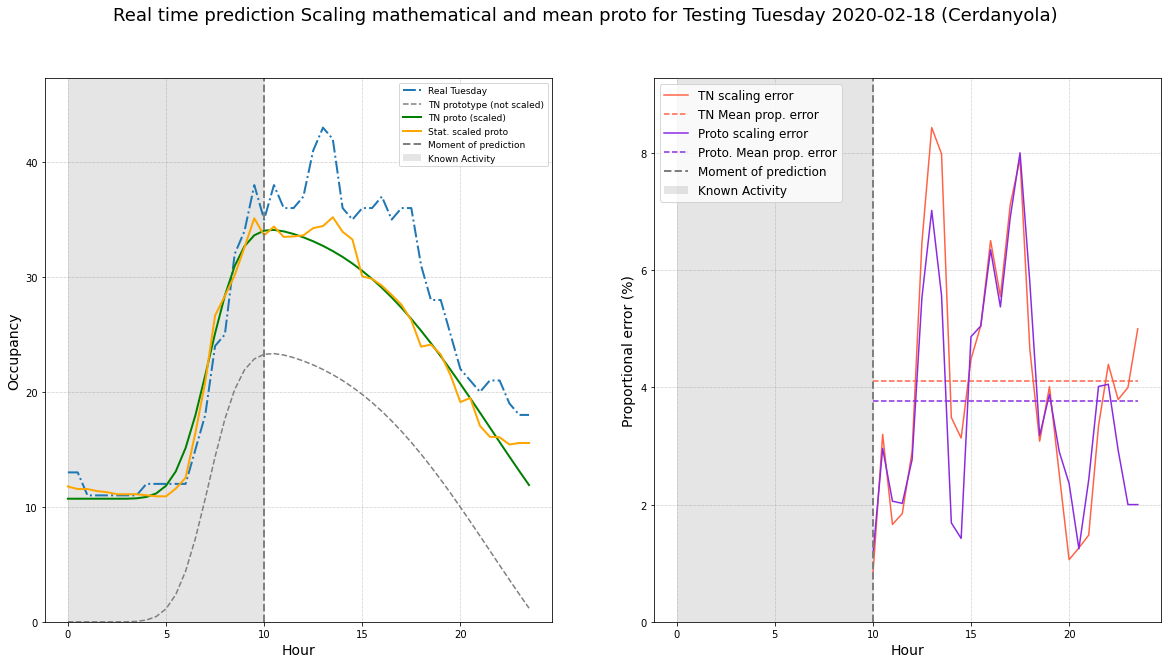

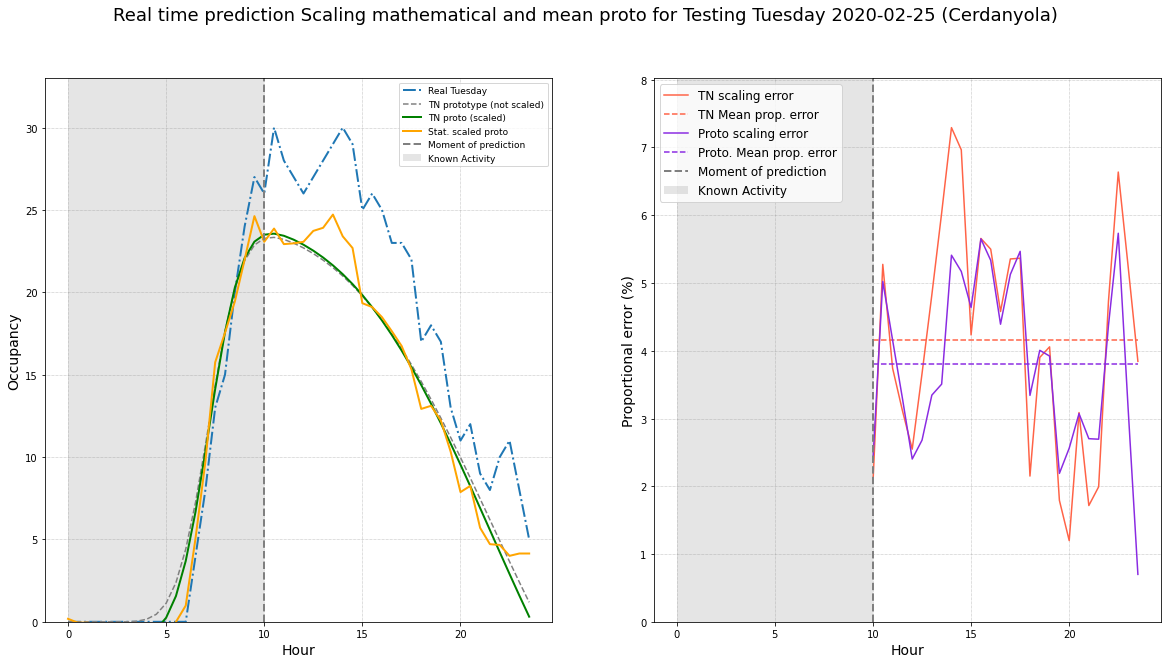

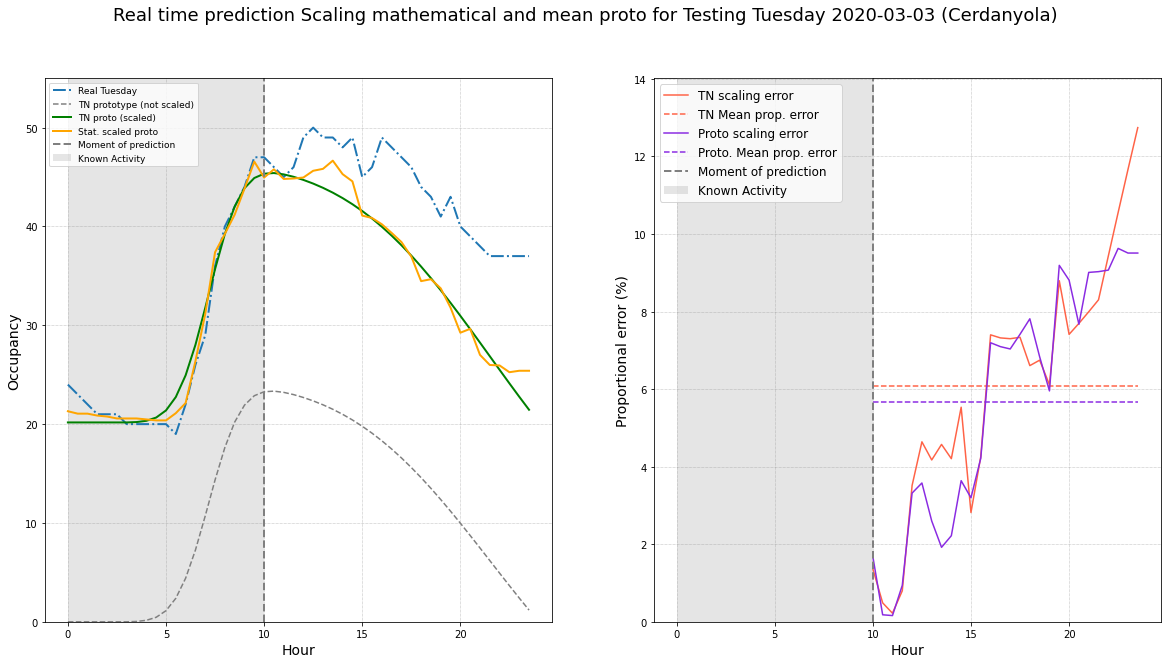

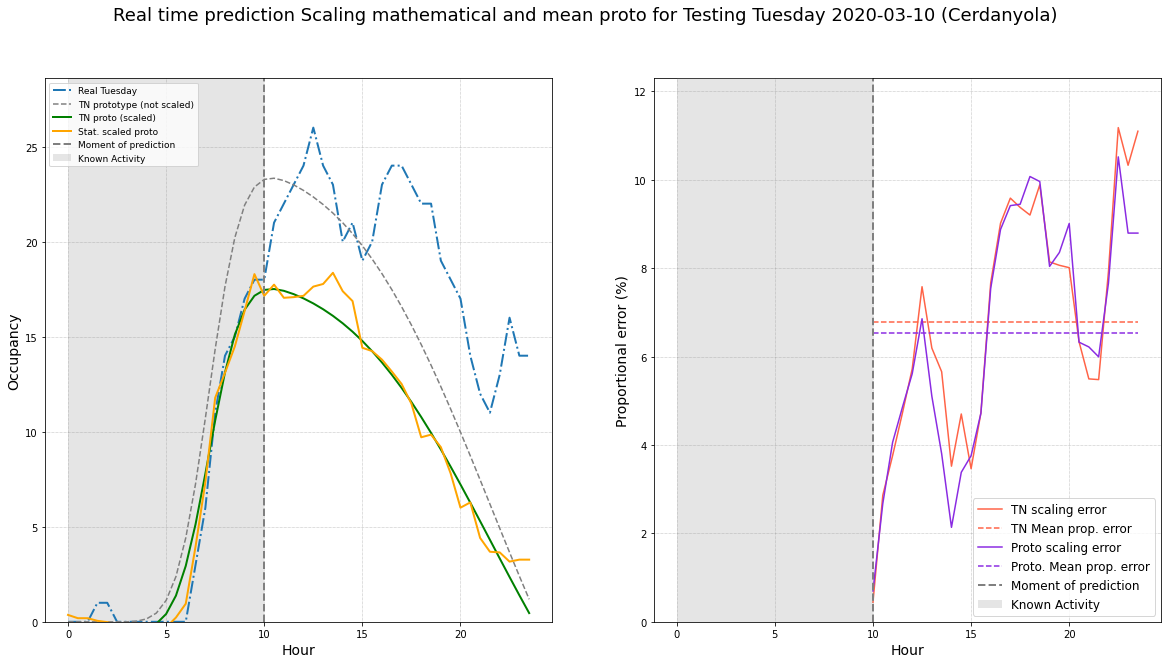

In [43]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

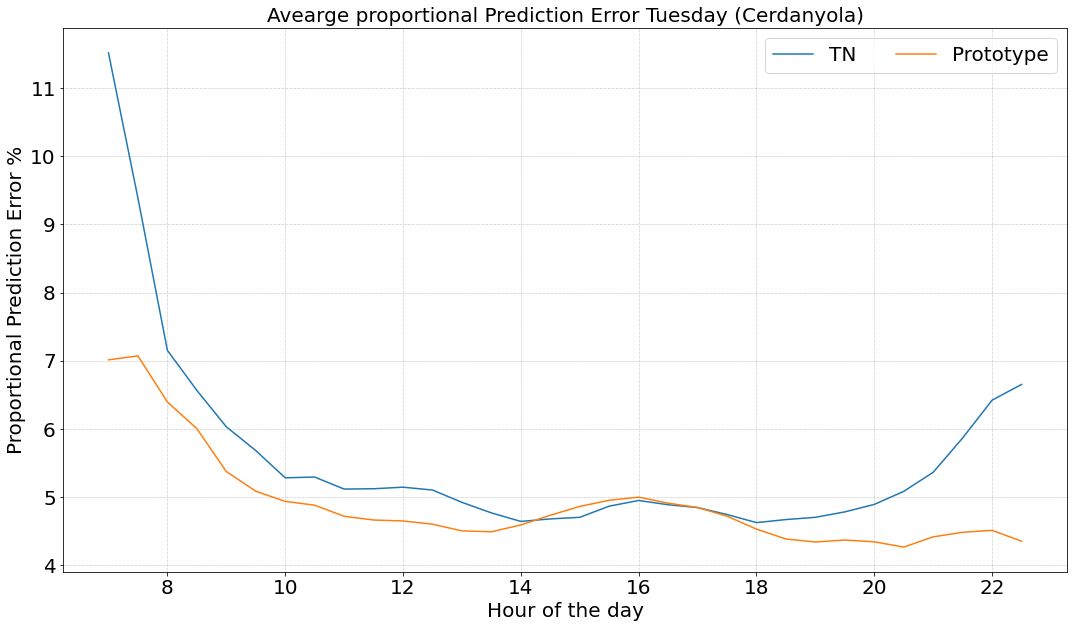

In [44]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [45]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

2020-02-18
Real Tuesday scaled prototype error:  3.69 %
Real Tuesday scaled prototype error (median):  3.96 %
Real Tuesday scaled prototype STDV: 2.0068504900975452
Real Tuesday scaled TN error:  4.12 %
Real Tuesday scaled TN error (median):  4.27 %
Real Tuesday scaled TN STDV:  2.141815164377272
_____________________________________________________________
2020-02-25
Real Tuesday scaled prototype error:  1.55 %
Real Tuesday scaled prototype error (median):  1.73 %
Real Tuesday scaled prototype STDV: 1.0288698464463806
Real Tuesday scaled TN error:  1.97 %
Real Tuesday scaled TN error (median):  1.82 %
Real Tuesday scaled TN STDV:  1.265418613727304
_____________________________________________________________
2020-03-03
Real Tuesday scaled prototype error:  7.26 %
Real Tuesday scaled prototype error (median):  7.68 %
Real Tuesday scaled prototype STDV: 5.533571486325614
Real Tuesday scaled TN error:  7.72 %
Real Tuesday scaled TN error (median):  8.13 %
Real Tuesday scaled TN STDV:  5

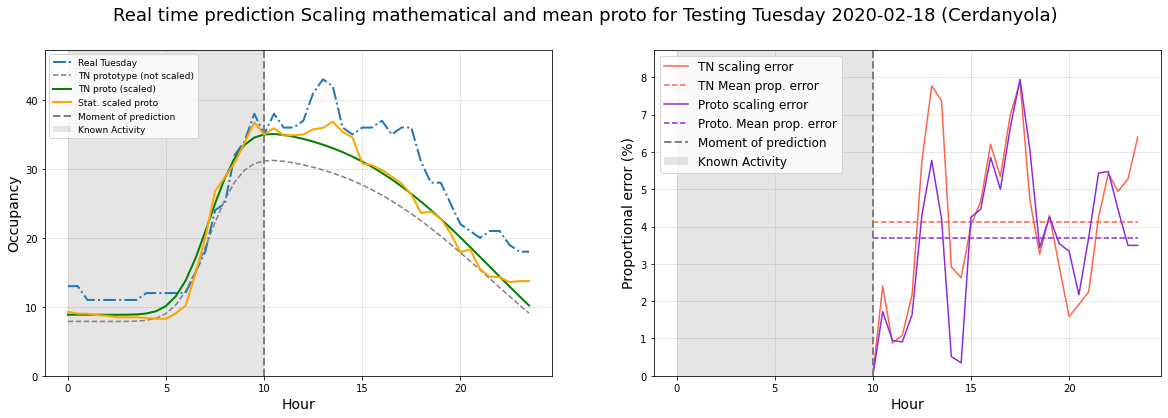

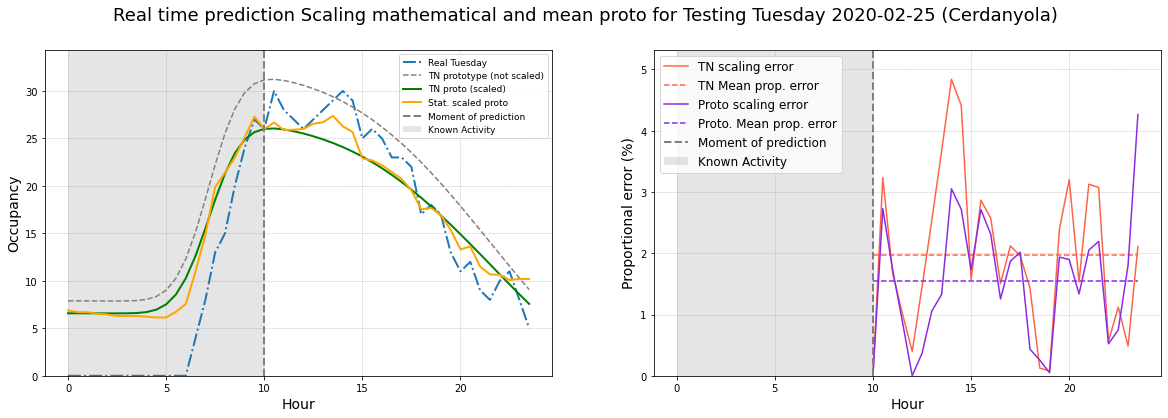

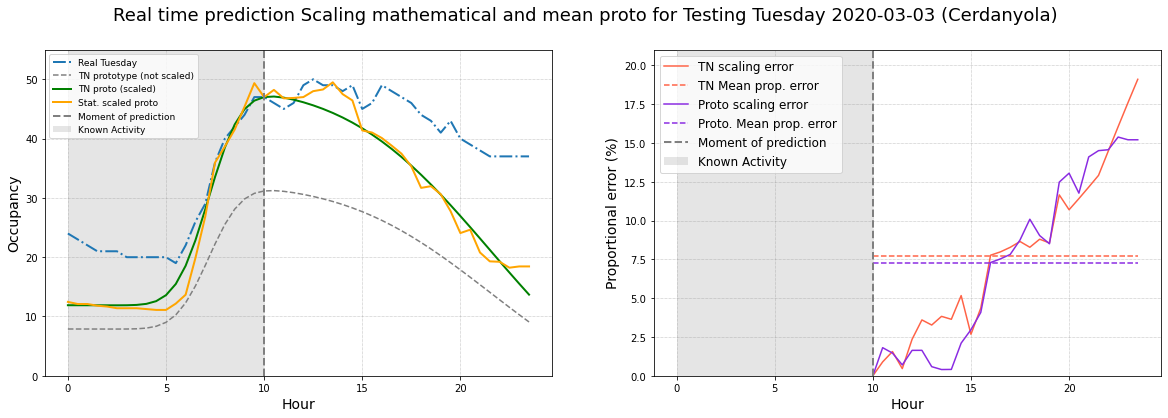

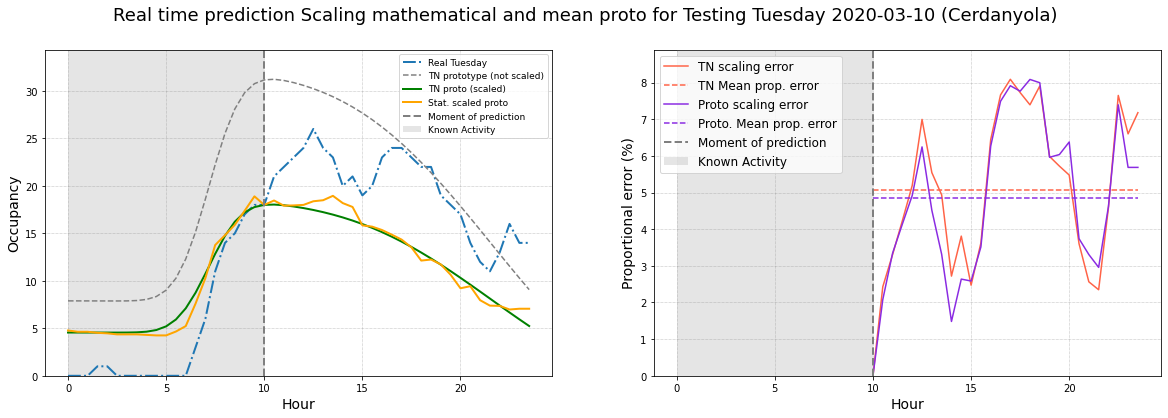

In [46]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### WEDNESDAY

In [47]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 13
day = 'Wednesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-19
Real Wednesday scaled prototype error:  4.04 %
Real Wednesday scaled prototype error (median):  3.57 %
Real Wednesday scaled prototype STDV: 3.13417562986925
Real Wednesday scaled TN error:  4.43 %
Real Wednesday scaled TN error (median):  3.76 %
Real Wednesday scaled TN STDV:  3.6839320305747347
_____________________________________________________________
2020-02-26
Real Wednesday scaled prototype error:  5.75 %
Real Wednesday scaled prototype error (median):  5.89 %
Real Wednesday scaled prototype STDV: 1.040987183050076
Real Wednesday scaled TN error:  5.39 %
Real Wednesday scaled TN error (median):  5.0 %
Real Wednesday scaled TN STDV:  1.2558386347451618
_____________________________________________________________
2020-03-04
Real Wednesday scaled prototype error:  9.09 %
Real Wednesday scaled prototype error (median):  9.87 %
Real Wednesday scaled prototype STDV: 2.29100092673064
Real Wednesday scaled TN error:  9.56 %
Real Wednesday scaled TN error (median):  9.62 %


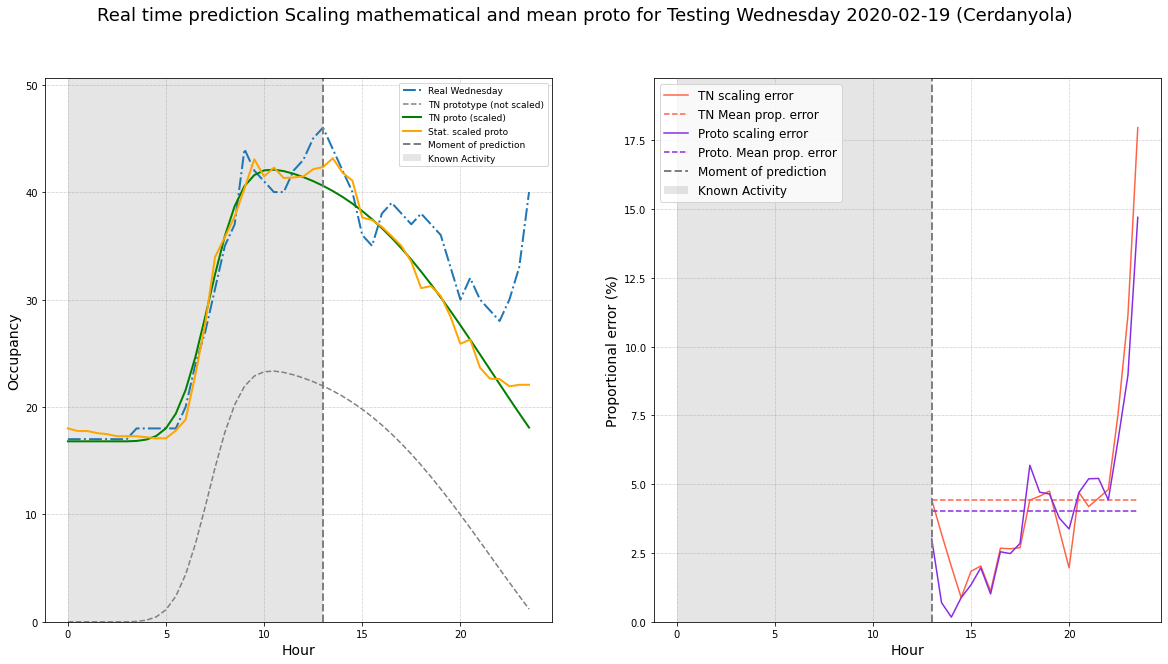

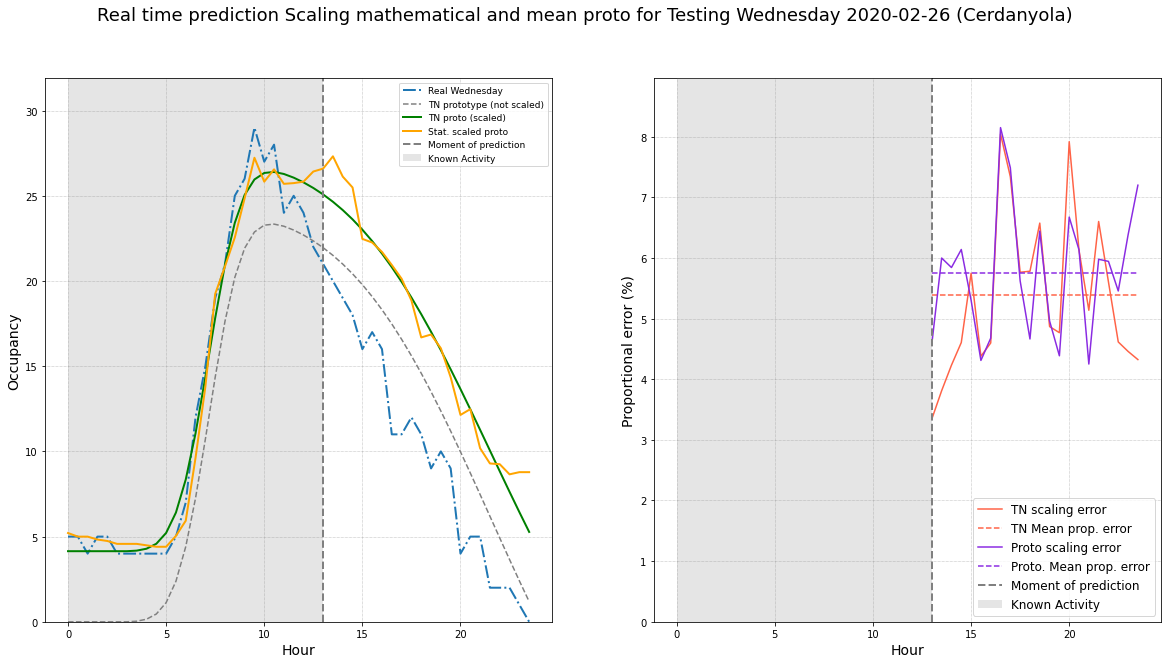

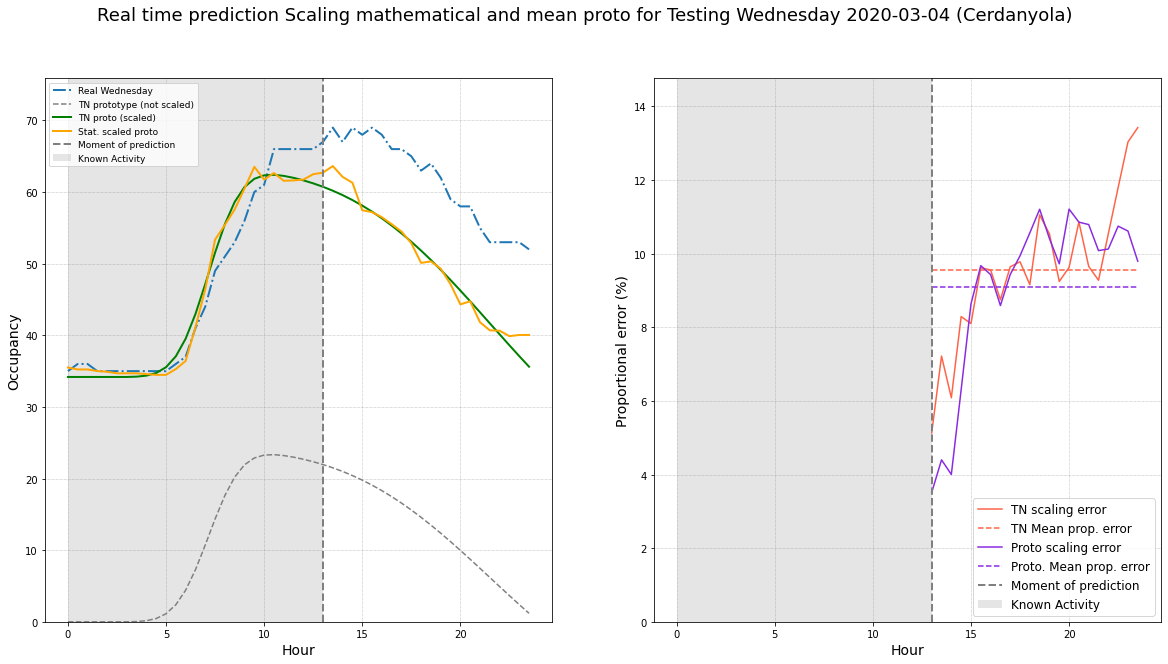

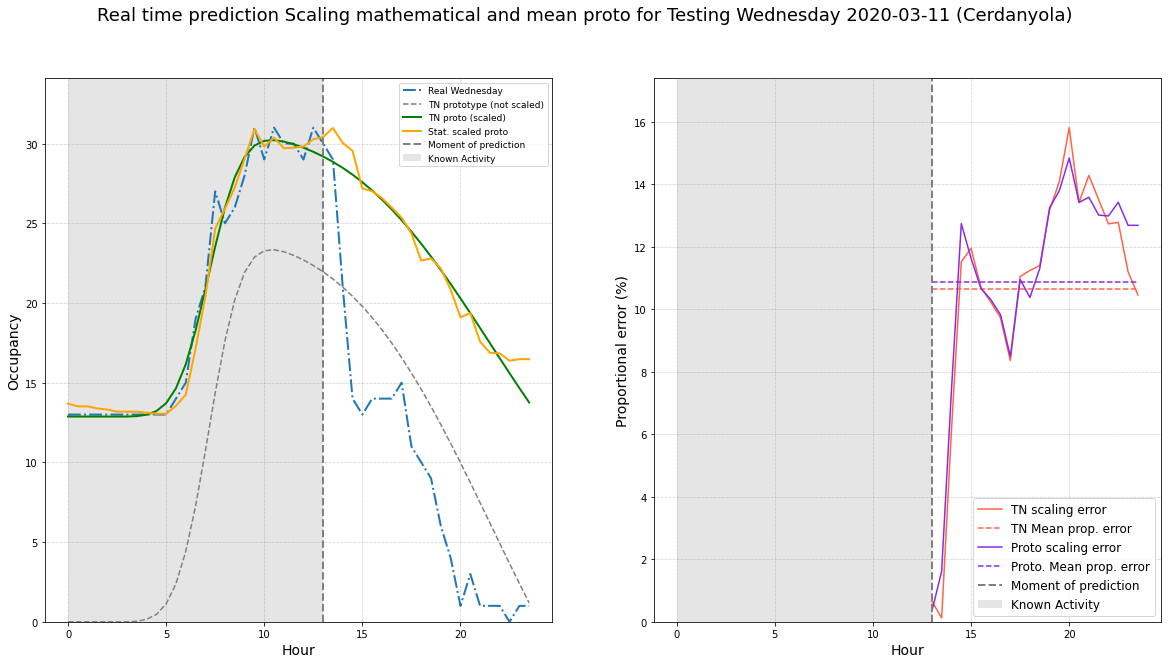

In [48]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

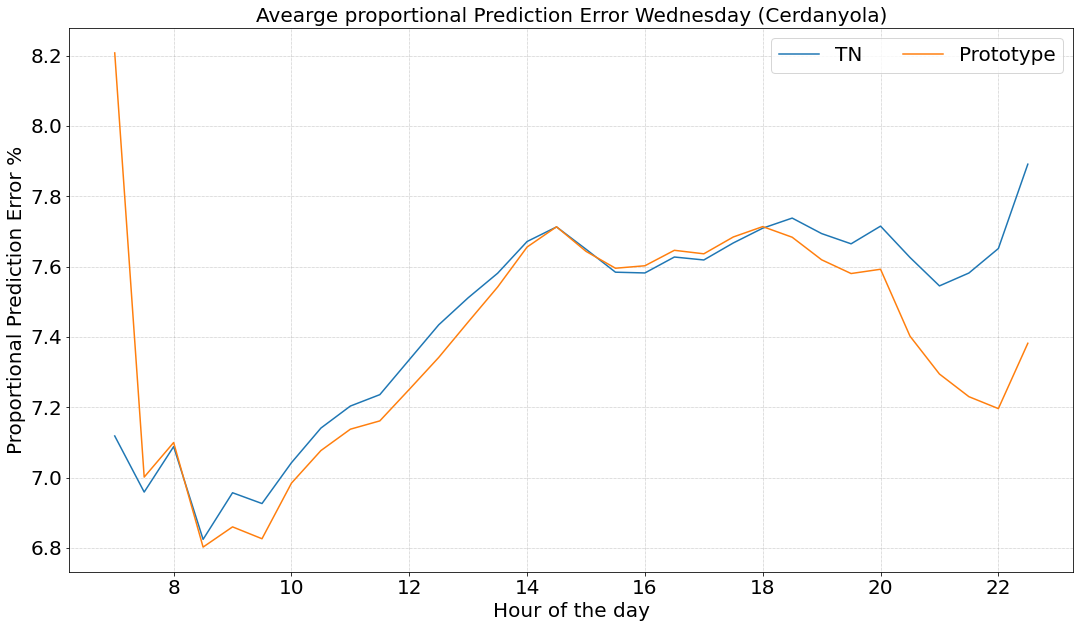

In [49]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [50]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

2020-02-19
Real Wednesday scaled prototype error:  5.6 %
Real Wednesday scaled prototype error (median):  5.36 %
Real Wednesday scaled prototype STDV: 4.2345269927709746
Real Wednesday scaled TN error:  4.7 %
Real Wednesday scaled TN error (median):  3.14 %
Real Wednesday scaled TN STDV:  4.890109733005879
_____________________________________________________________
2020-02-26
Real Wednesday scaled prototype error:  3.29 %
Real Wednesday scaled prototype error (median):  3.04 %
Real Wednesday scaled prototype STDV: 1.8331233727025067
Real Wednesday scaled TN error:  3.86 %
Real Wednesday scaled TN error (median):  4.35 %
Real Wednesday scaled TN STDV:  1.9428162750797227
_____________________________________________________________
2020-03-04
Real Wednesday scaled prototype error:  13.8 %
Real Wednesday scaled prototype error (median):  15.79 %
Real Wednesday scaled prototype STDV: 7.403538106444651
Real Wednesday scaled TN error:  11.96 %
Real Wednesday scaled TN error (median):  11.

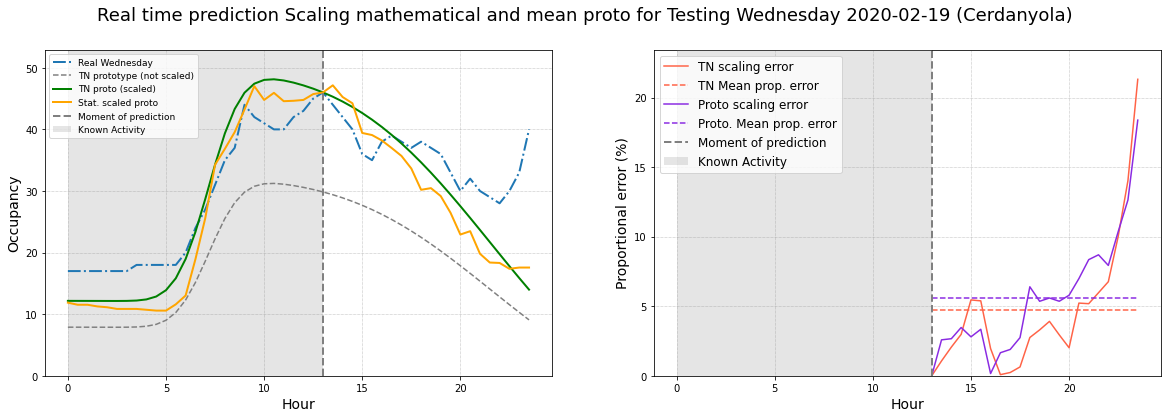

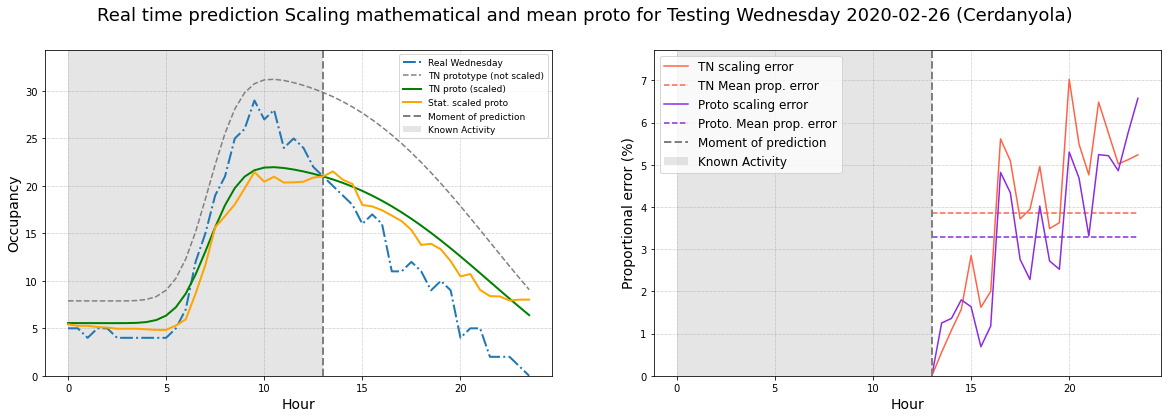

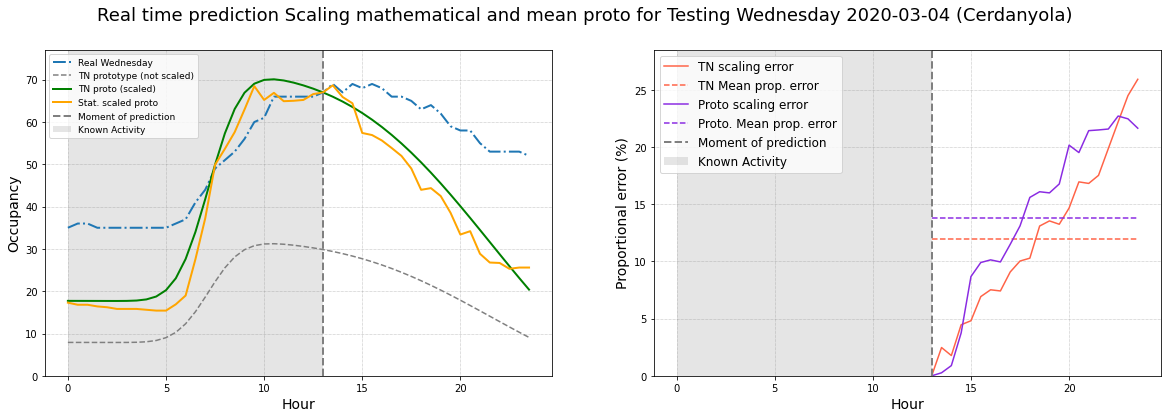

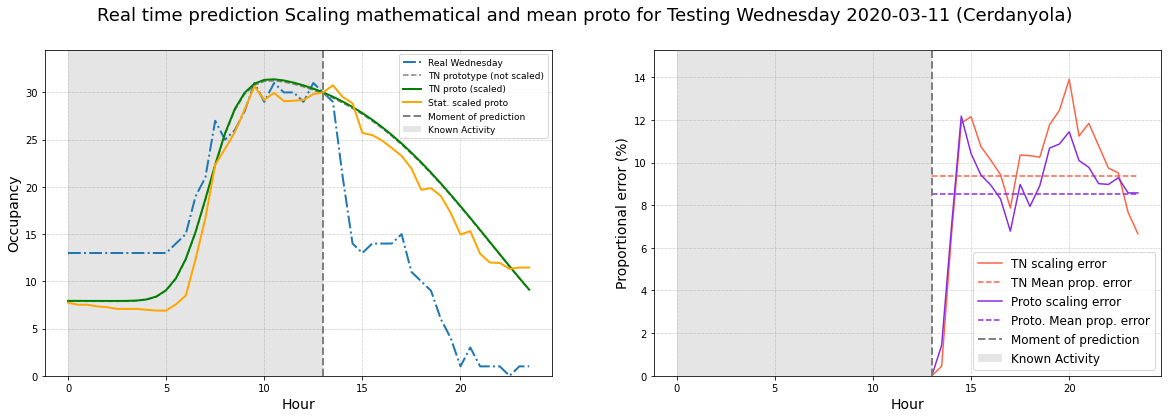

In [51]:
tn_proto = tn_weekday
cont=0        
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### THURSDAY

In [52]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 7.5
day = 'Thursday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-20
Real Thursday scaled prototype error:  19.61 %
Real Thursday scaled prototype error (median):  21.57 %
Real Thursday scaled prototype STDV: 8.851033309451092
Real Thursday scaled TN error:  22.27 %
Real Thursday scaled TN error (median):  22.78 %
Real Thursday scaled TN STDV:  9.462335400766618
_____________________________________________________________
2020-02-27
Real Thursday scaled prototype error:  1.74 %
Real Thursday scaled prototype error (median):  0.82 %
Real Thursday scaled prototype STDV: 1.9746256178906163
Real Thursday scaled TN error:  1.74 %
Real Thursday scaled TN error (median):  0.82 %
Real Thursday scaled TN STDV:  1.9746261772839289
_____________________________________________________________
2020-03-05
Real Thursday scaled prototype error:  4.22 %
Real Thursday scaled prototype error (median):  2.7 %
Real Thursday scaled prototype STDV: 4.121177528560568
Real Thursday scaled TN error:  3.64 %
Real Thursday scaled TN error (median):  1.84 %
Real Thursd

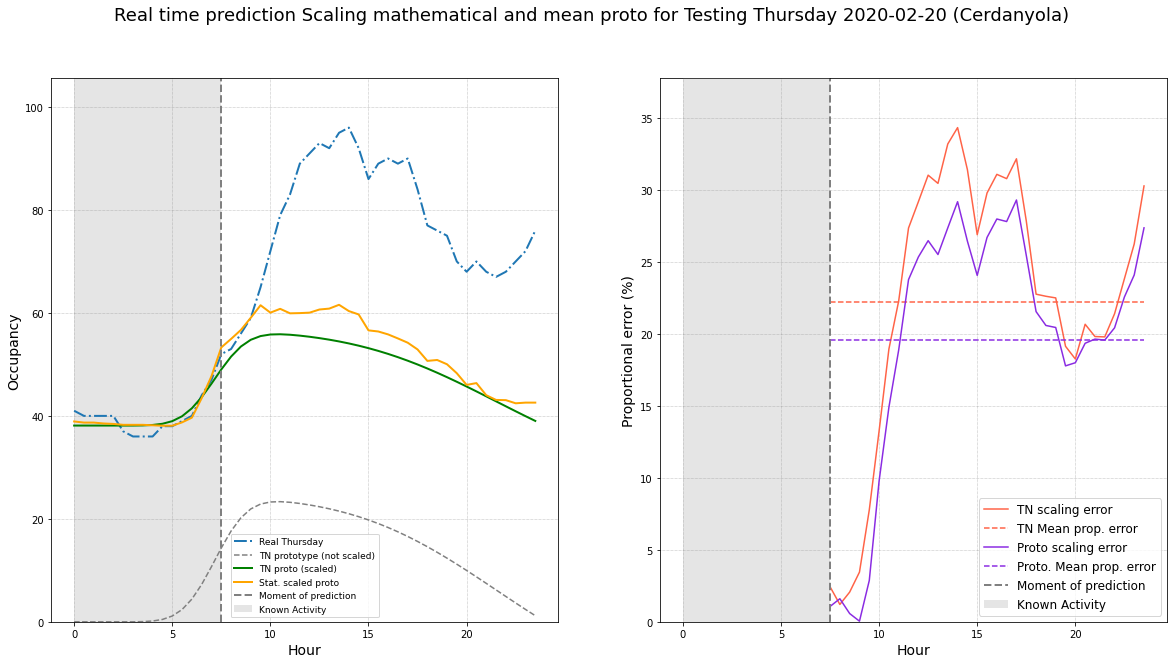

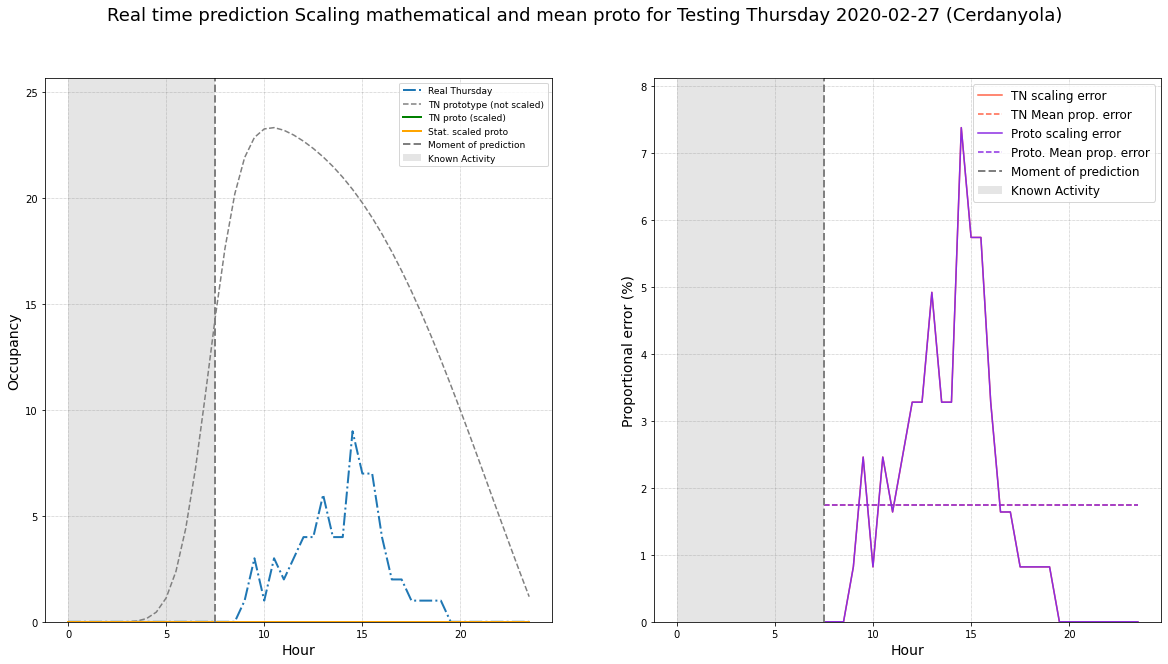

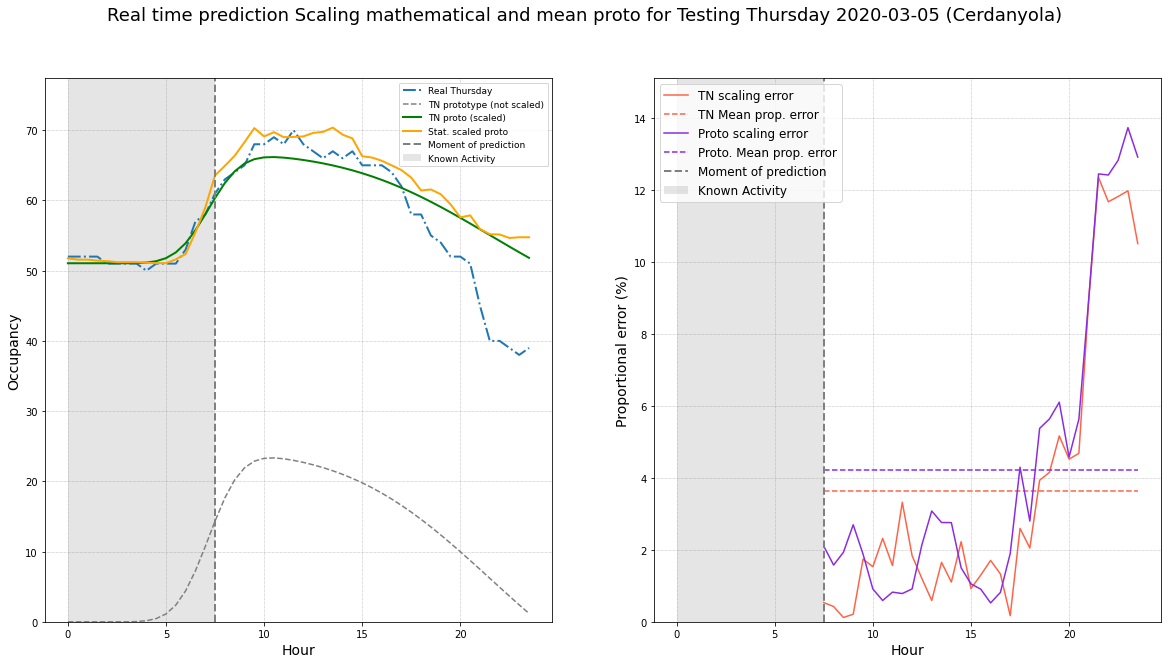

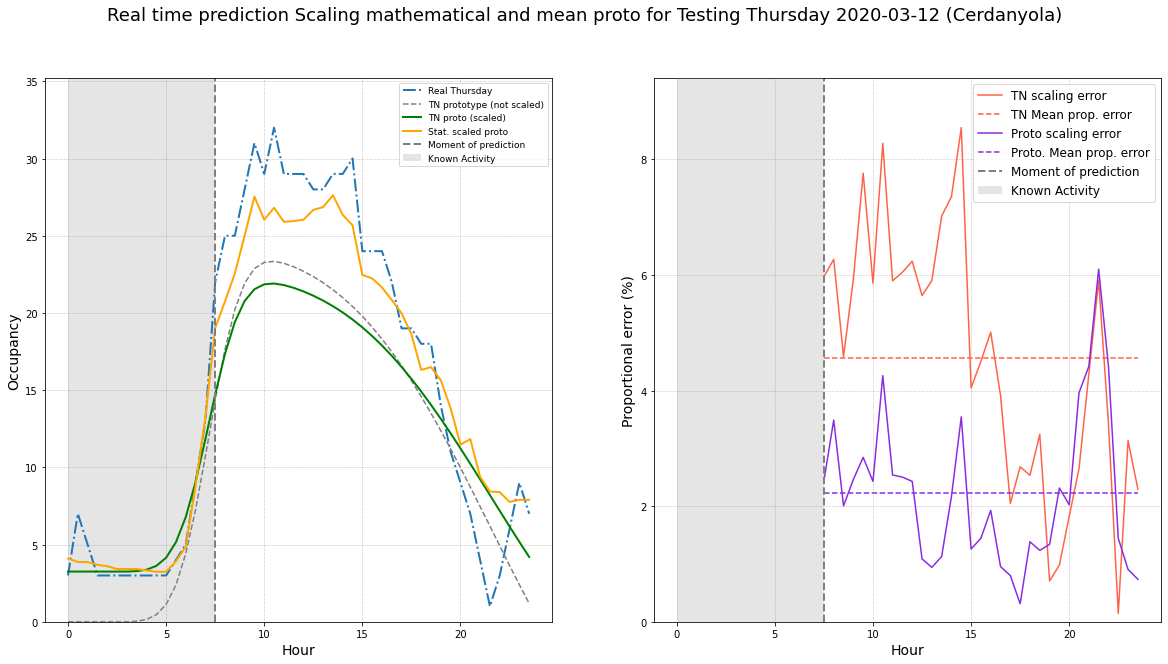

In [53]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

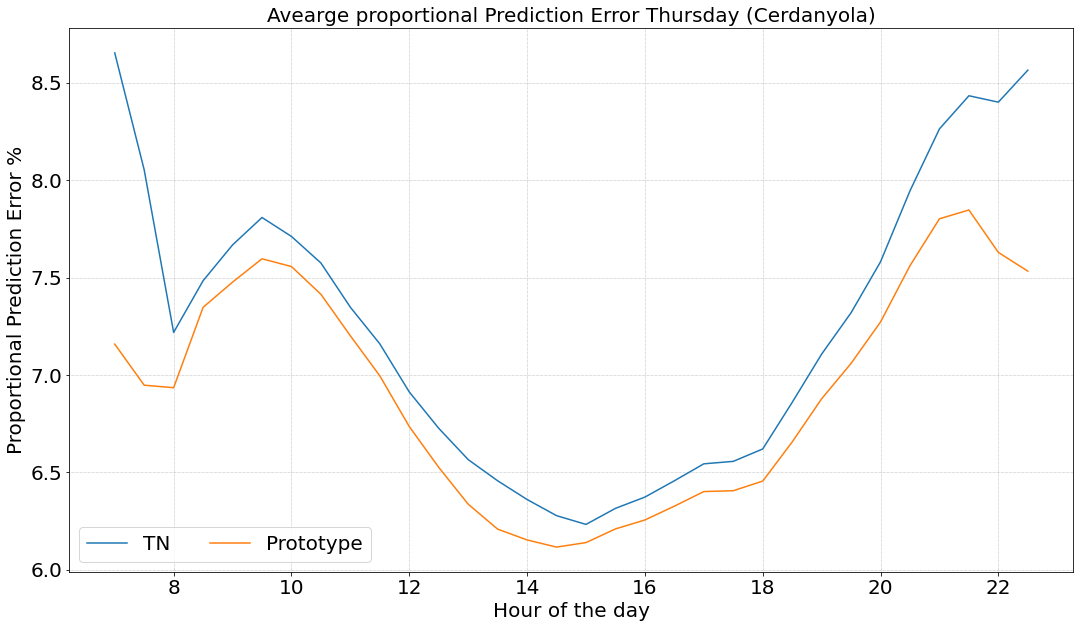

In [54]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

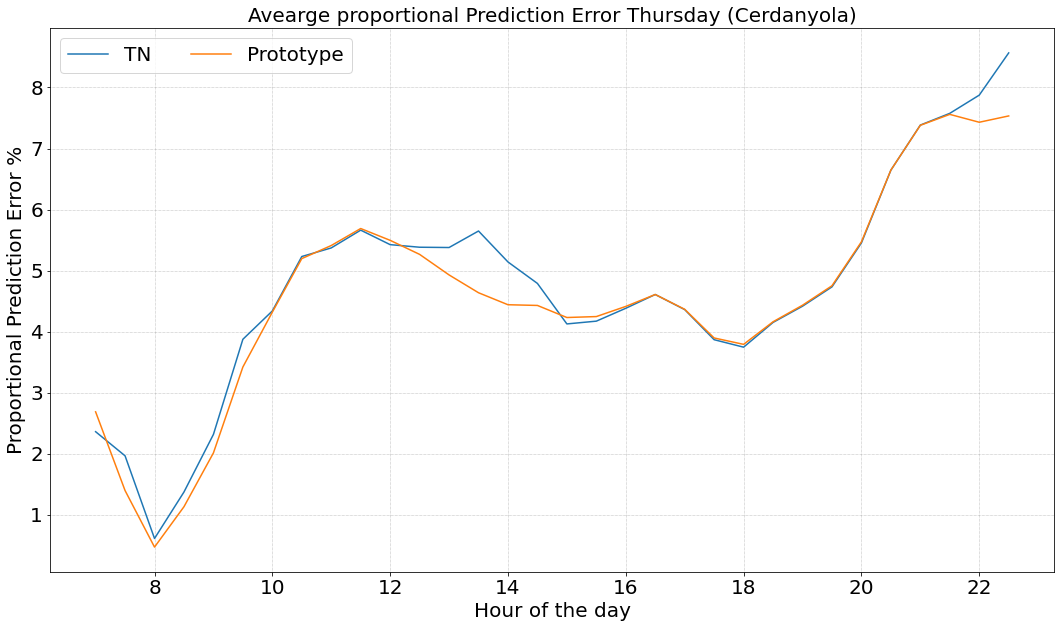

In [55]:
[tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNow(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour,1)
plotRunningPredcitionError(tn_running_error_vec_now,proto_running_error_vec_now,starting_hour,day,current_parking)

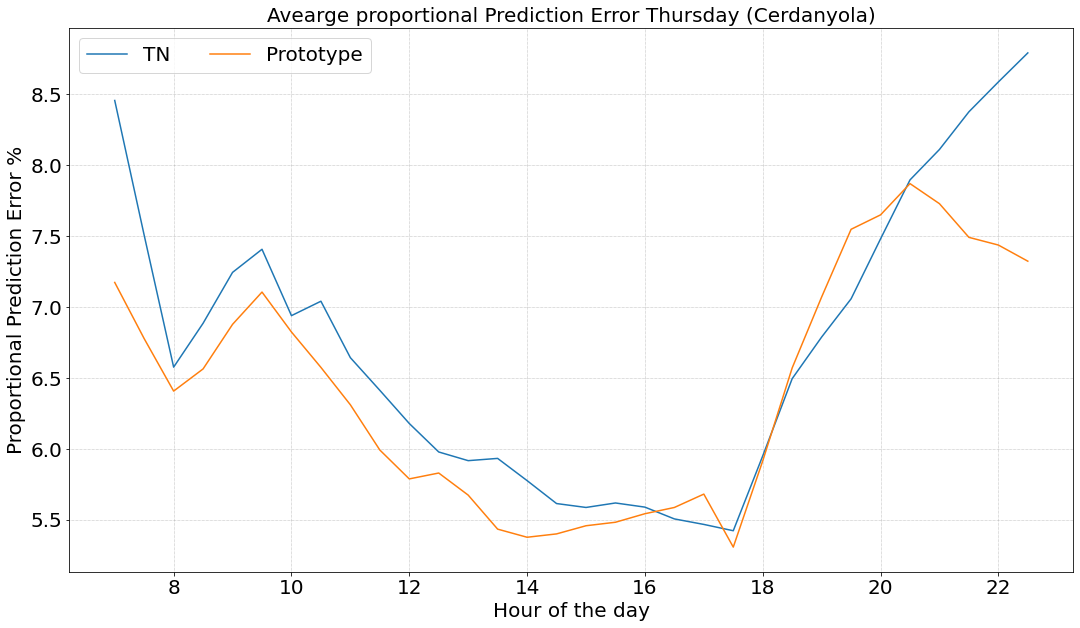

In [56]:
[tn_running_error_vec_med,proto_running_error_vec_med]=calcRunningPredcitionErrorMedian(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec_med,proto_running_error_vec_med,starting_hour,day,current_parking)

In [57]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

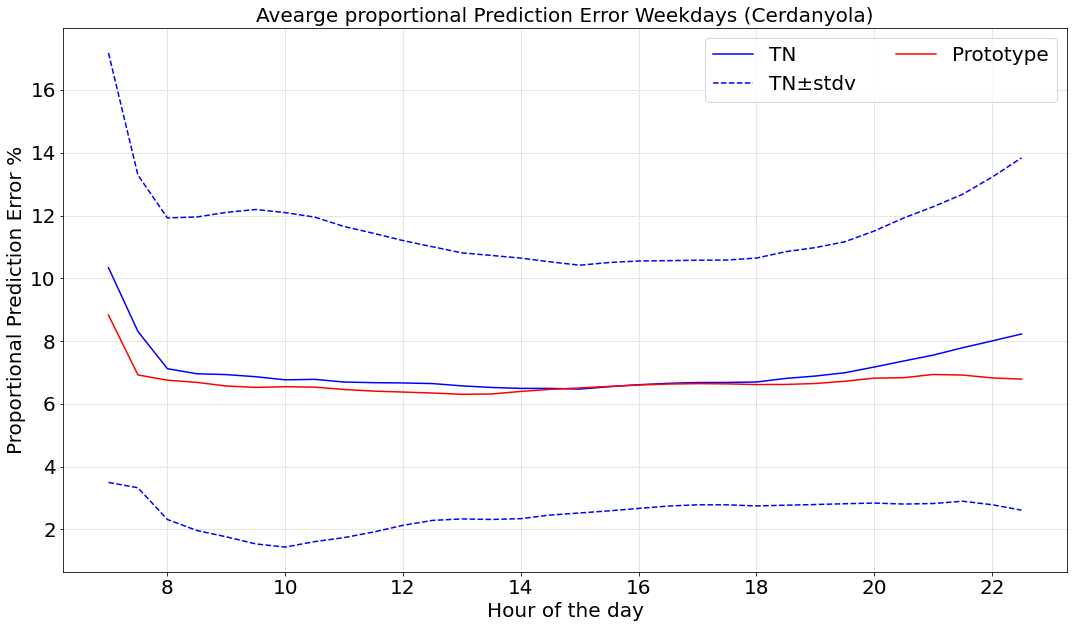

In [58]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_wd,proto_running_error_wd,starting_hour,"Weekdays",current_parking)

2020-02-20
Real Thursday scaled prototype error:  21.07 %
Real Thursday scaled prototype error (median):  24.34 %
Real Thursday scaled prototype STDV: 10.65303798717052
Real Thursday scaled TN error:  19.64 %
Real Thursday scaled TN error (median):  21.26 %
Real Thursday scaled TN STDV:  10.279836127612876
_____________________________________________________________
2020-02-27
Real Thursday scaled prototype error:  1.74 %
Real Thursday scaled prototype error (median):  0.82 %
Real Thursday scaled prototype STDV: 1.9746256248735012
Real Thursday scaled TN error:  1.74 %
Real Thursday scaled TN error (median):  0.82 %
Real Thursday scaled TN STDV:  1.9746256248735012
_____________________________________________________________
2020-03-05
Real Thursday scaled prototype error:  6.57 %
Real Thursday scaled prototype error (median):  6.32 %
Real Thursday scaled prototype STDV: 3.9482187150479127
Real Thursday scaled TN error:  7.61 %
Real Thursday scaled TN error (median):  7.36 %
Real Thu

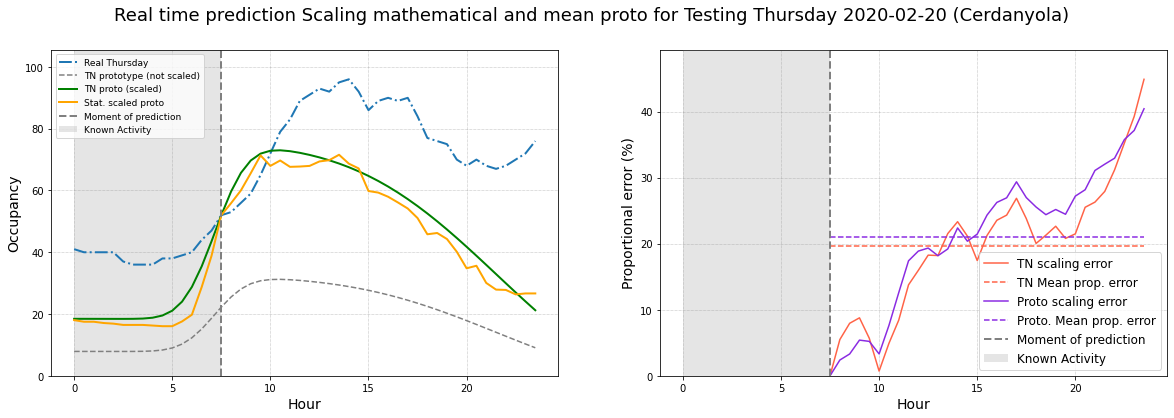

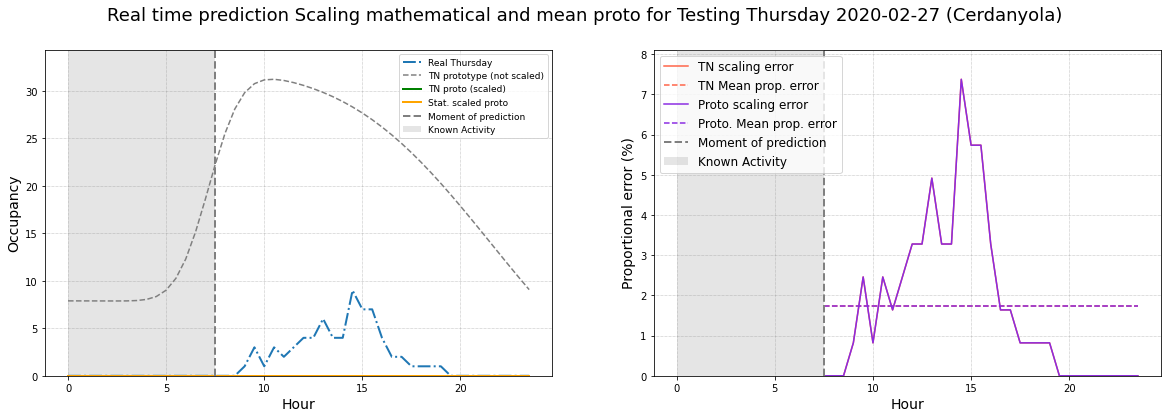

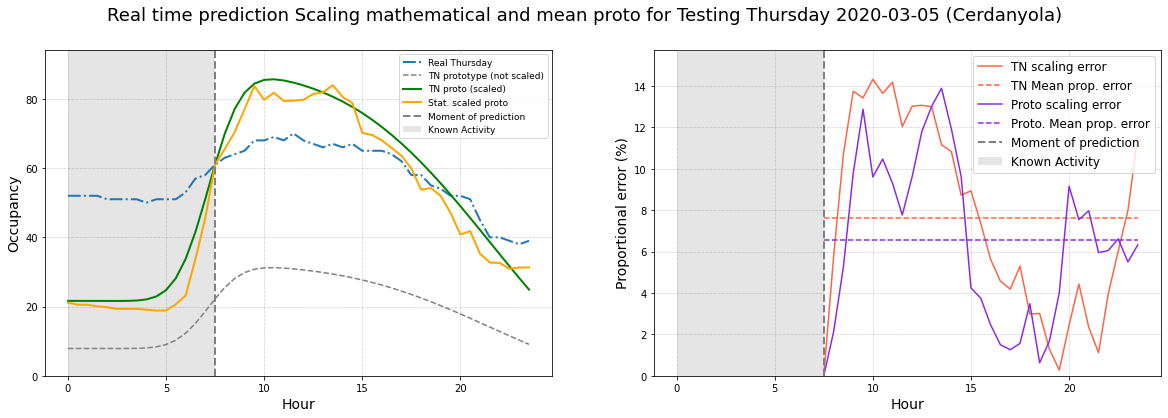

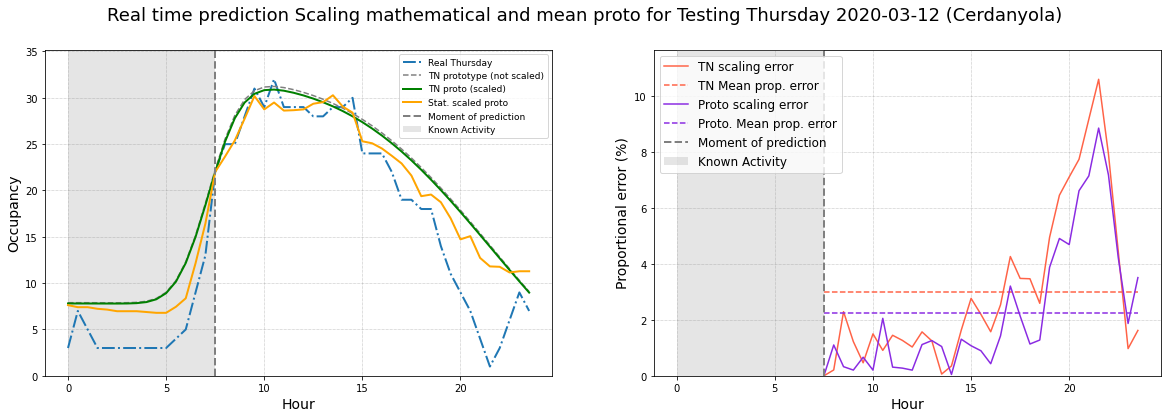

In [59]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1
    

### FRIDAY

In [60]:
statistic_proto = hist_friday_proto
tn_proto = tn_friday_nooff
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 16
day = 'Friday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-21
Real Friday scaled prototype error:  48.28 %
Real Friday scaled prototype error (median):  48.84 %
Real Friday scaled prototype STDV: 13.133937914891987
Real Friday scaled TN error:  41.77 %
Real Friday scaled TN error (median):  42.46 %
Real Friday scaled TN STDV:  12.444487368045252
_____________________________________________________________
2020-02-28
Real Friday scaled prototype error:  2.12 %
Real Friday scaled prototype error (median):  1.65 %
Real Friday scaled prototype STDV: 1.3935144392183947
Real Friday scaled TN error:  1.91 %
Real Friday scaled TN error (median):  1.91 %
Real Friday scaled TN STDV:  1.0856925865138598
_____________________________________________________________
2020-03-06
Real Friday scaled prototype error:  4.39 %
Real Friday scaled prototype error (median):  4.4 %
Real Friday scaled prototype STDV: 2.0469933483808296
Real Friday scaled TN error:  2.36 %
Real Friday scaled TN error (median):  2.44 %
Real Friday scaled TN STDV:  1.47734384265

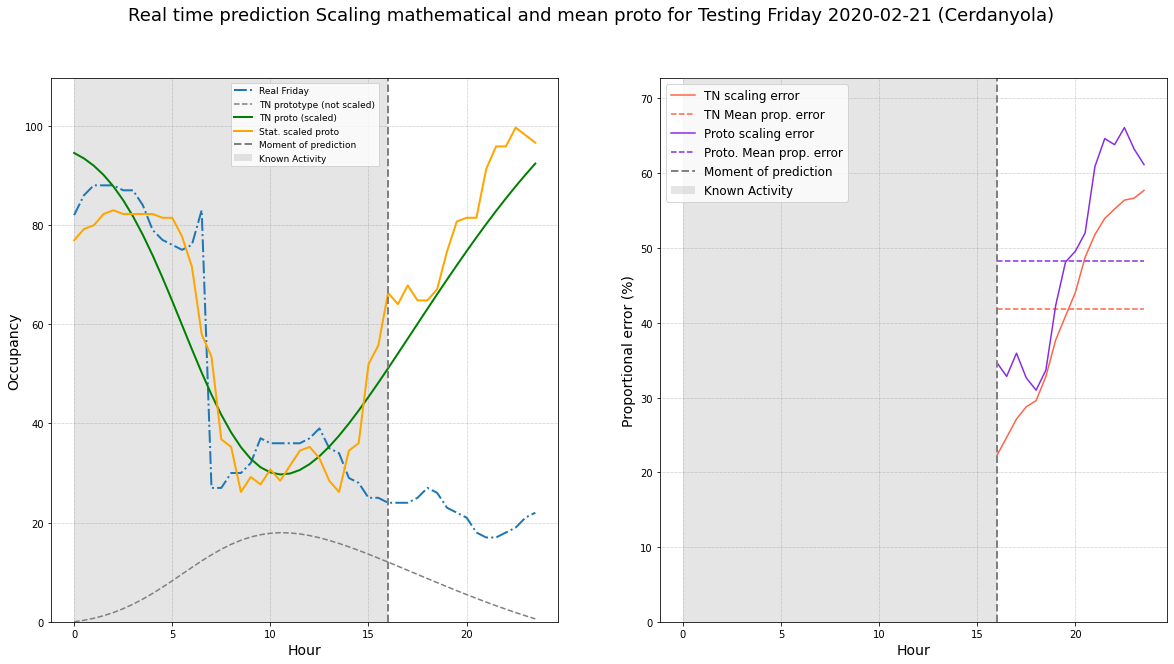

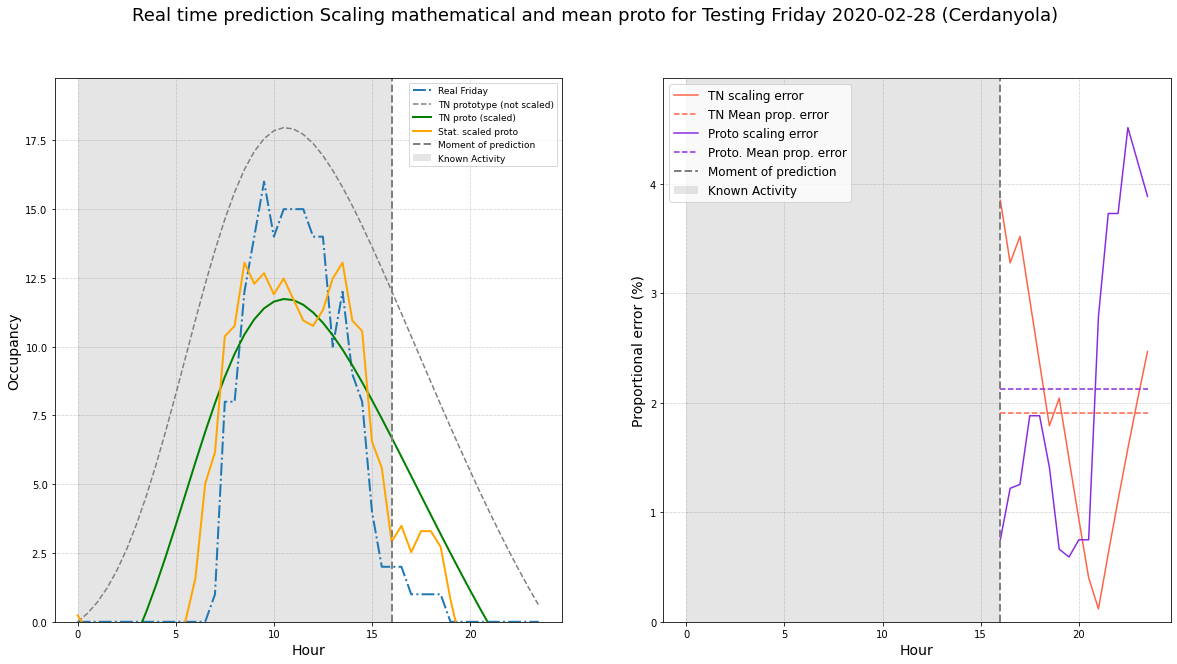

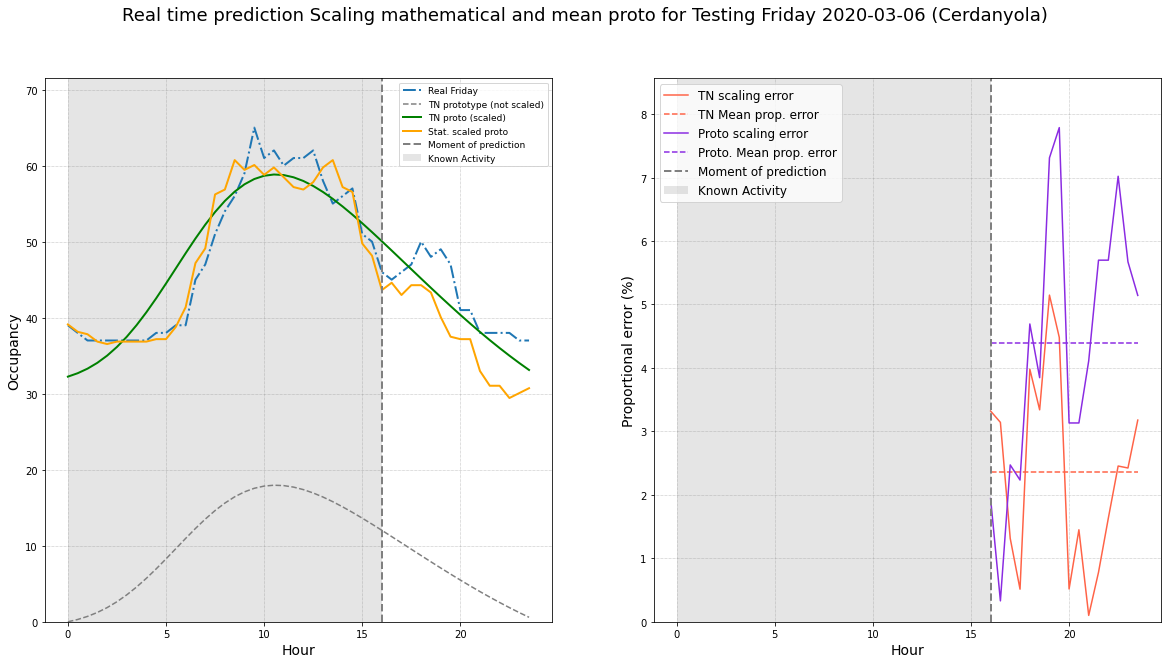

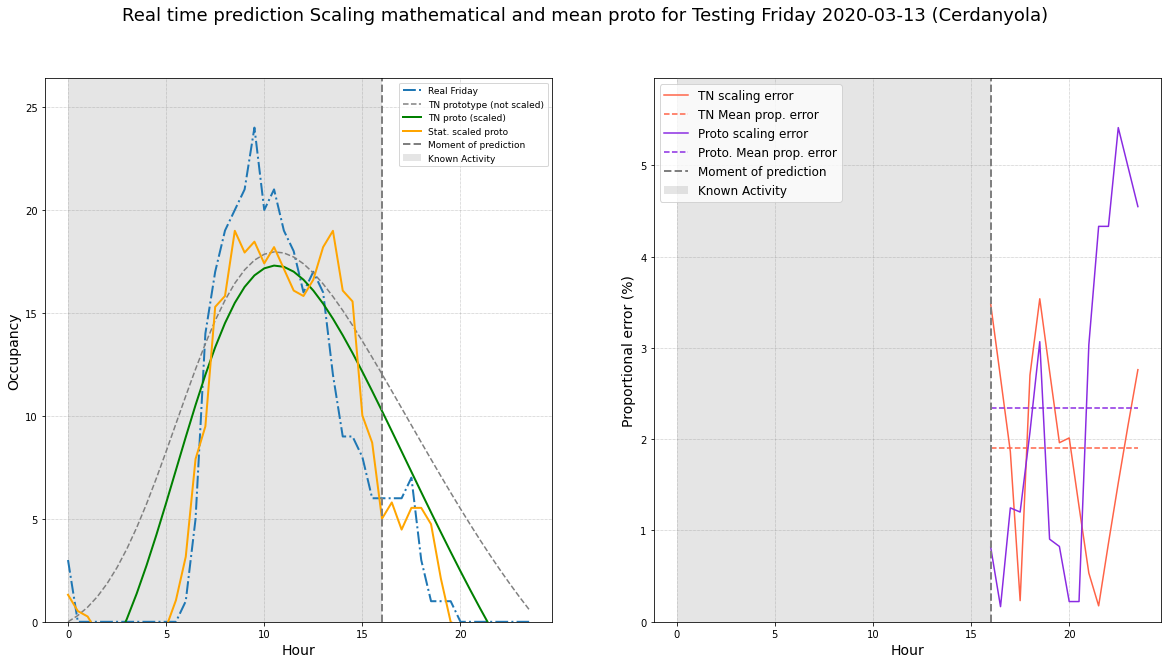

In [61]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

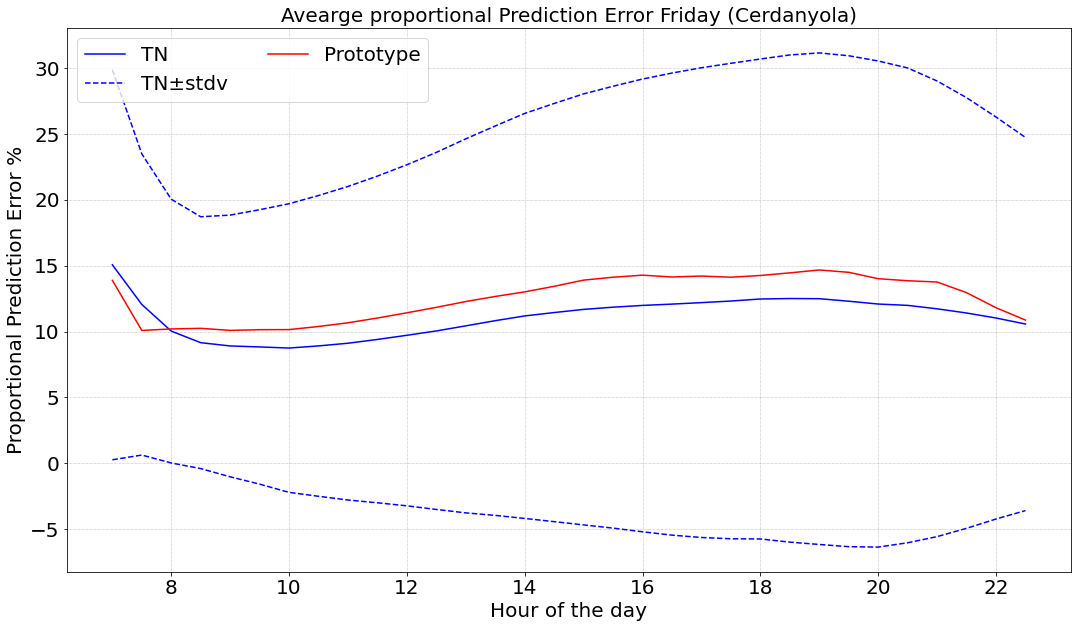

In [62]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
figH=plotRunningPredcitionErrorSTDV(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [63]:
proto_running_error_fr=proto_running_error_vec
tn_running_error_fr=tn_running_error_vec

2020-02-21
Real Friday scaled prototype error:  1.86 %
Real Friday scaled prototype error (median):  1.34 %
Real Friday scaled prototype STDV: 1.6643675606907695
Real Friday scaled TN error:  3.31 %
Real Friday scaled TN error (median):  3.22 %
Real Friday scaled TN STDV:  2.2061535394384397
_____________________________________________________________
2020-02-28
Real Friday scaled prototype error:  0.94 %
Real Friday scaled prototype error (median):  1.01 %
Real Friday scaled prototype STDV: 0.40053869394756414
Real Friday scaled TN error:  0.81 %
Real Friday scaled TN error (median):  0.89 %
Real Friday scaled TN STDV:  0.3666903609717683
_____________________________________________________________
2020-03-06
Real Friday scaled prototype error:  4.35 %
Real Friday scaled prototype error (median):  4.01 %
Real Friday scaled prototype STDV: 2.9117194385540364
Real Friday scaled TN error:  7.32 %
Real Friday scaled TN error (median):  8.23 %
Real Friday scaled TN STDV:  3.4513929499988

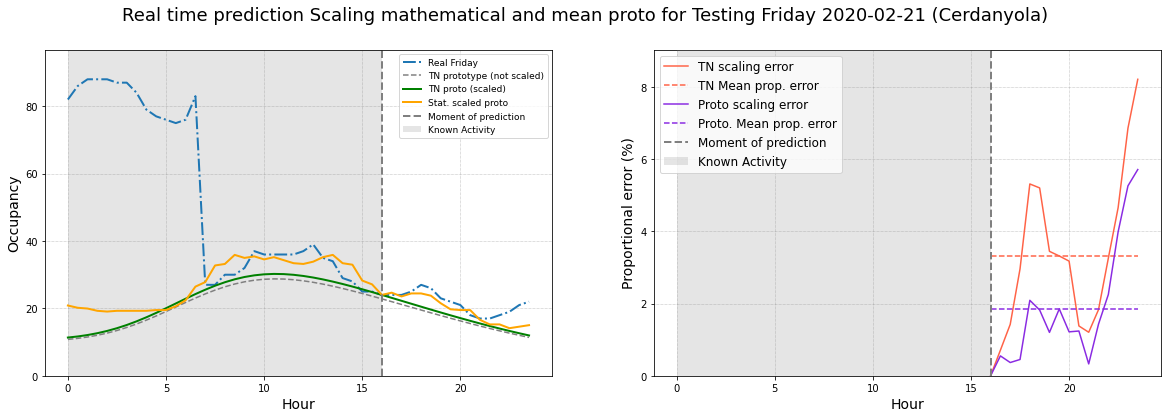

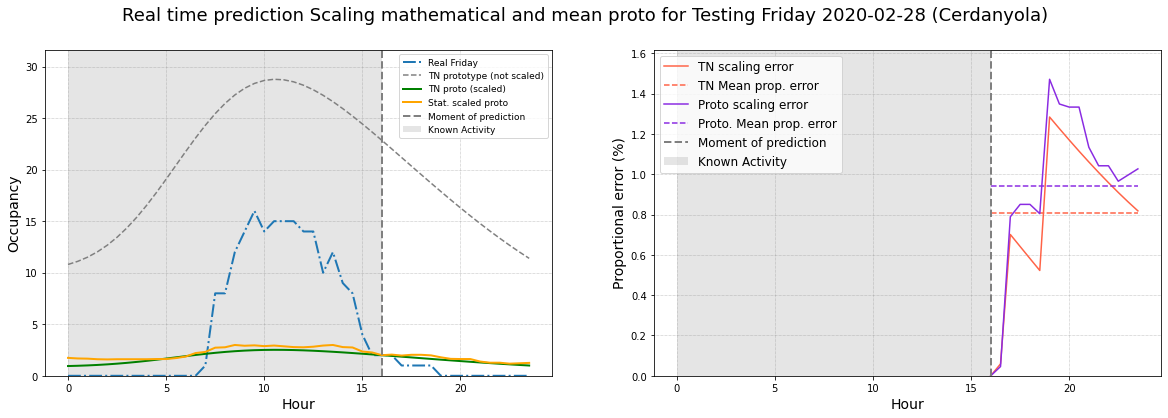

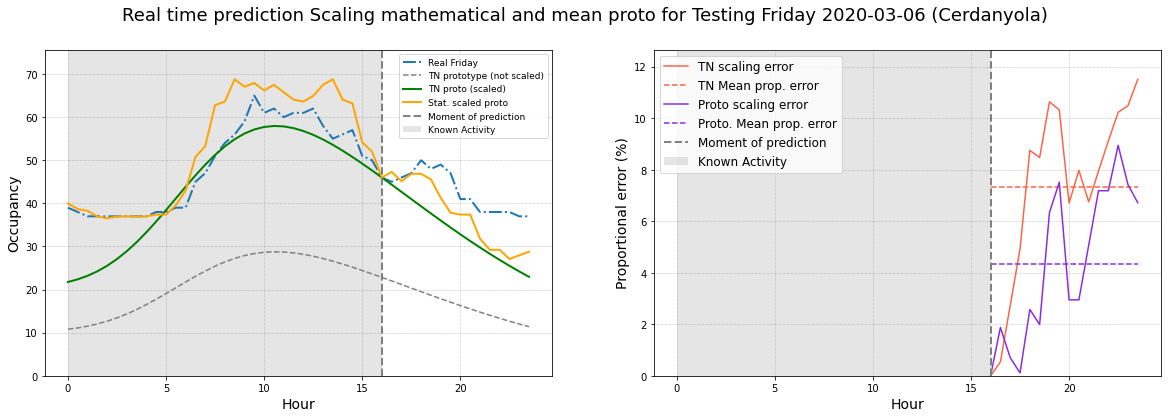

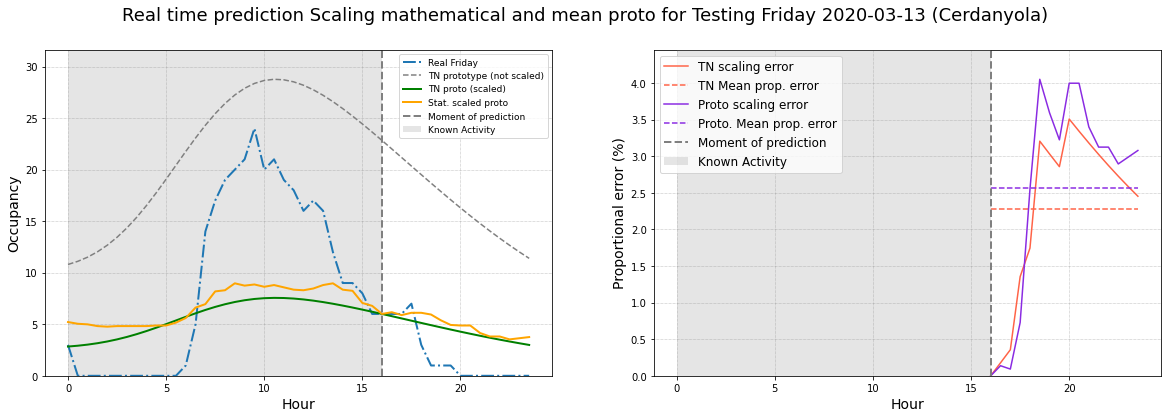

In [64]:
tn_proto = tn_friday 
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1
    

### WEEKEND

### SATURDAY

In [65]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-22
Real Saturday scaled prototype error:  6.23 %
Real Saturday scaled prototype error (median):  6.07 %
Real Saturday scaled prototype STDV: 2.8568840169750254
Real Saturday scaled TN error:  5.37 %
Real Saturday scaled TN error (median):  6.08 %
Real Saturday scaled TN STDV:  3.033891462246902
_____________________________________________________________
2020-03-07
Real Saturday scaled prototype error:  1.19 %
Real Saturday scaled prototype error (median):  0.95 %
Real Saturday scaled prototype STDV: 0.7366318120583801
Real Saturday scaled TN error:  1.28 %
Real Saturday scaled TN error (median):  1.39 %
Real Saturday scaled TN STDV:  0.8192083493982218
_____________________________________________________________


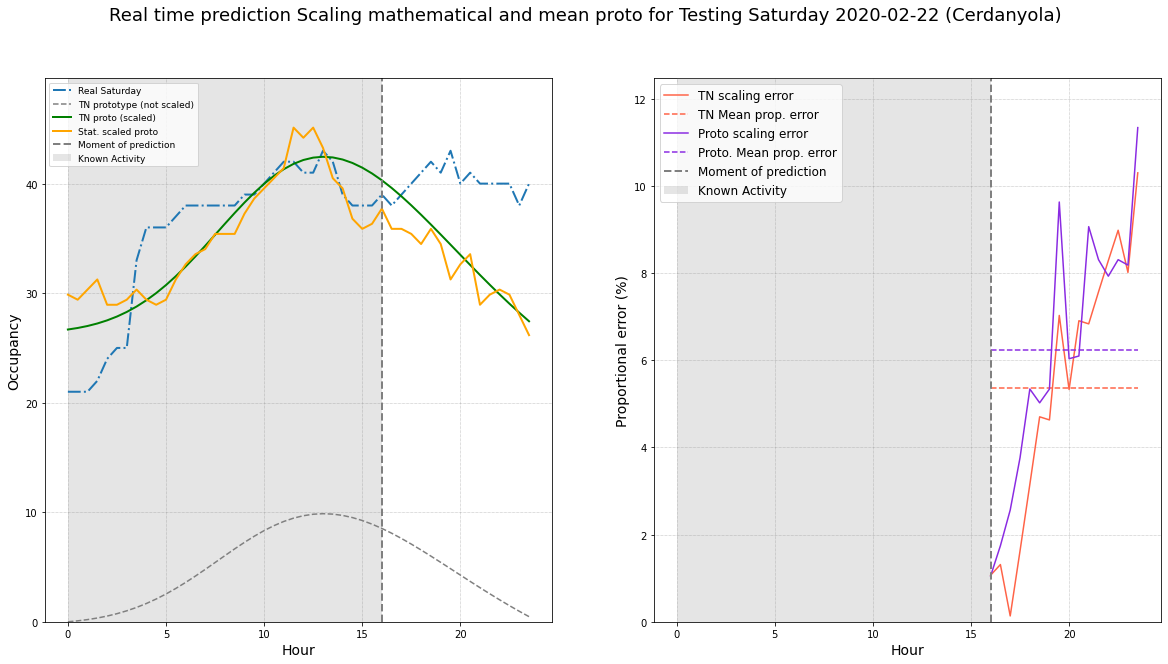

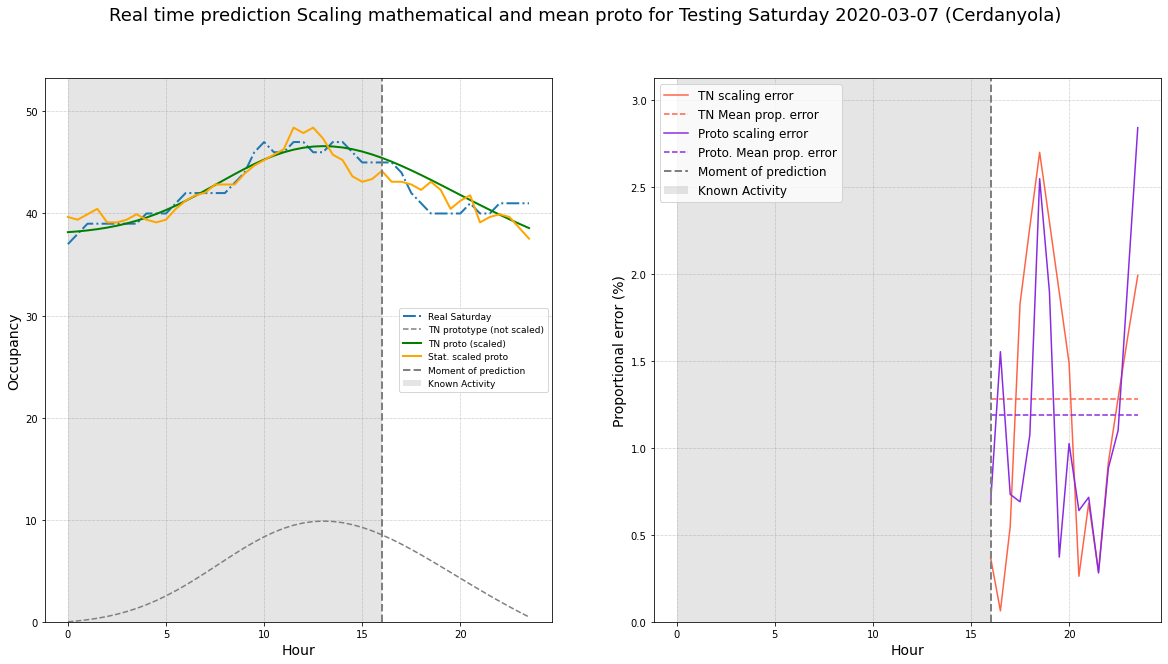

In [66]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

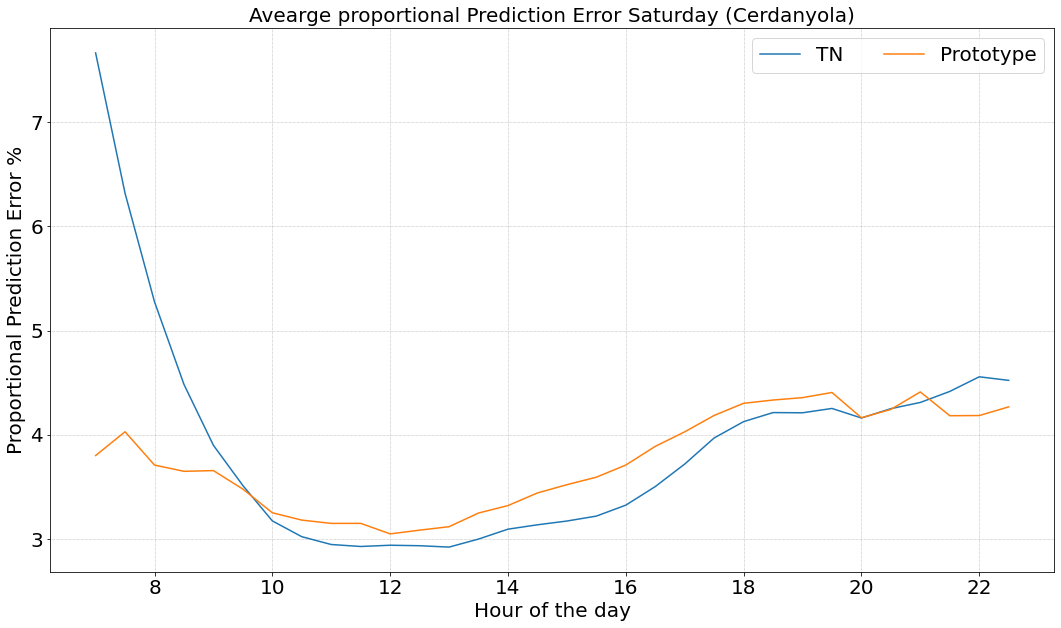

In [67]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [68]:
proto_running_error_we=proto_running_error_vec
tn_running_error_we=tn_running_error_vec

2020-02-22
Real Saturday scaled prototype error:  6.29 %
Real Saturday scaled prototype error (median):  6.0 %
Real Saturday scaled prototype STDV: 3.5161934855933334
Real Saturday scaled TN error:  5.6 %
Real Saturday scaled TN error (median):  6.46 %
Real Saturday scaled TN STDV:  3.093024298808323
_____________________________________________________________
2020-03-07
Real Saturday scaled prototype error:  3.49 %
Real Saturday scaled prototype error (median):  2.08 %
Real Saturday scaled prototype STDV: 3.060439486086265
Real Saturday scaled TN error:  2.62 %
Real Saturday scaled TN error (median):  1.24 %
Real Saturday scaled TN STDV:  2.5568629397502822
_____________________________________________________________


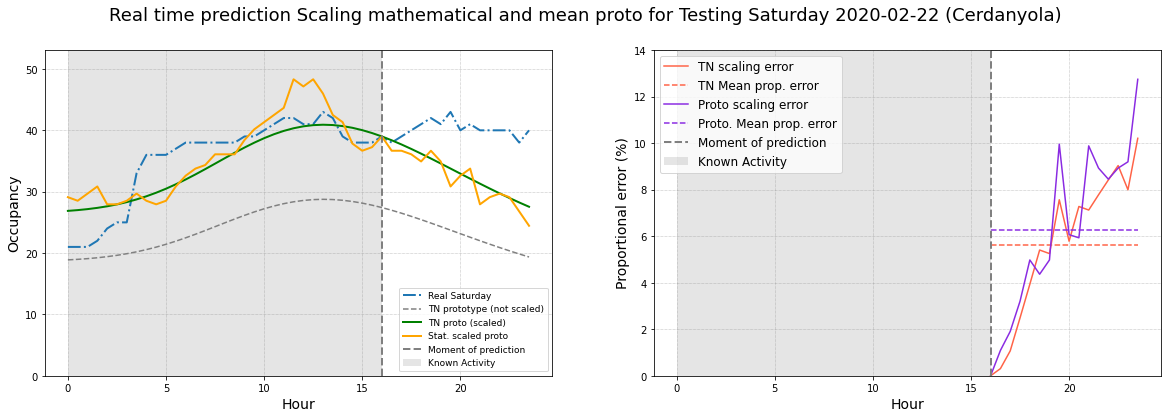

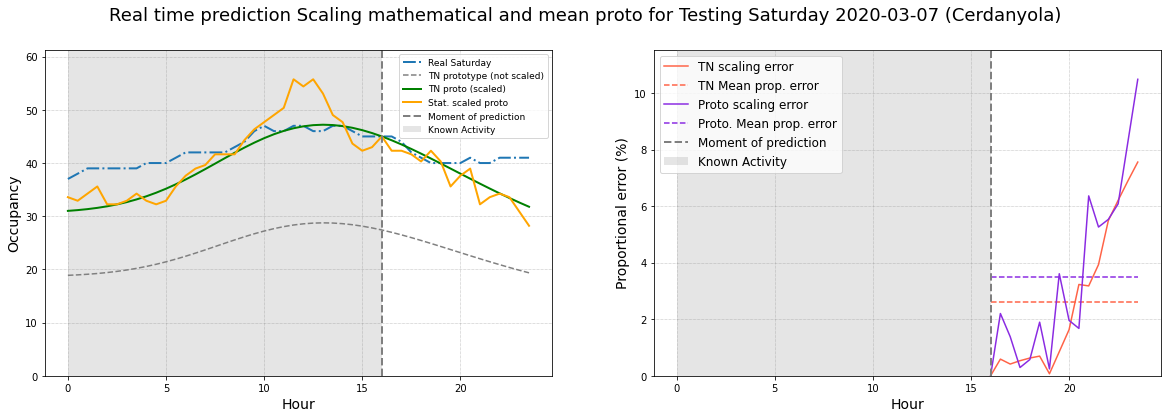

In [69]:
tn_proto = tn1_weekend        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### SUNDAY

In [70]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
    

2020-02-23
Real Sunday scaled prototype error:  5.93 %
Real Sunday scaled prototype error (median):  5.93 %
Real Sunday scaled prototype STDV: 1.3202391889372551
Real Sunday scaled TN error:  5.41 %
Real Sunday scaled TN error (median):  5.39 %
Real Sunday scaled TN STDV:  1.106811391316338
_____________________________________________________________
2020-03-08
Real Sunday scaled prototype error:  4.14 %
Real Sunday scaled prototype error (median):  4.33 %
Real Sunday scaled prototype STDV: 2.303293965735084
Real Sunday scaled TN error:  3.44 %
Real Sunday scaled TN error (median):  3.66 %
Real Sunday scaled TN STDV:  2.4495465503319314
_____________________________________________________________


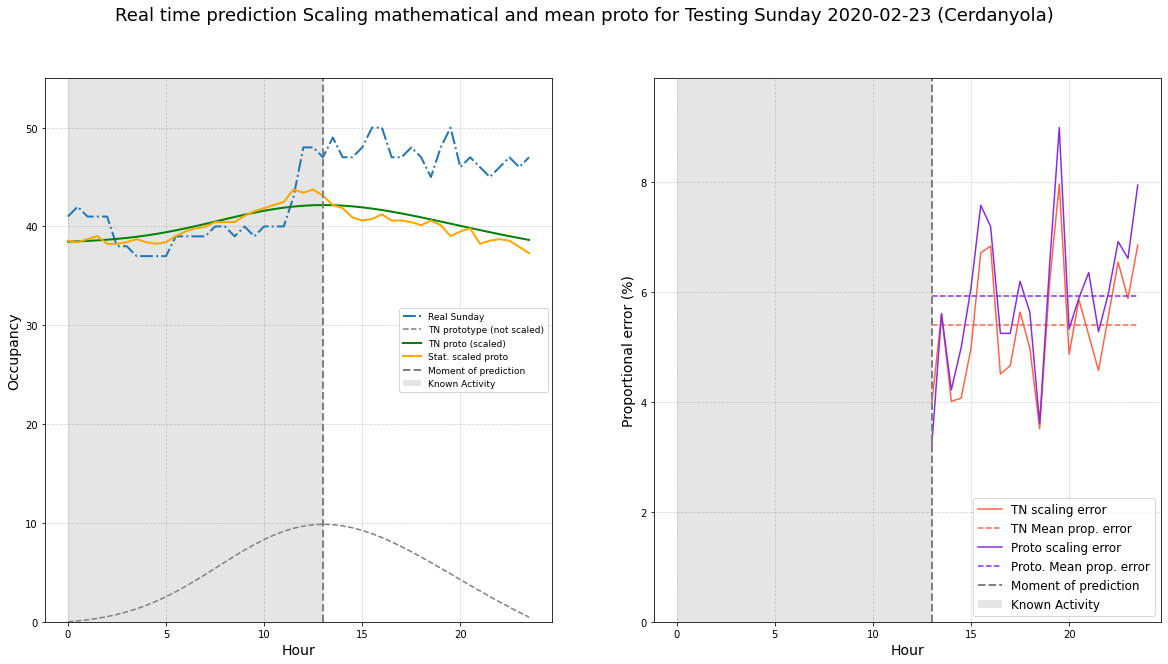

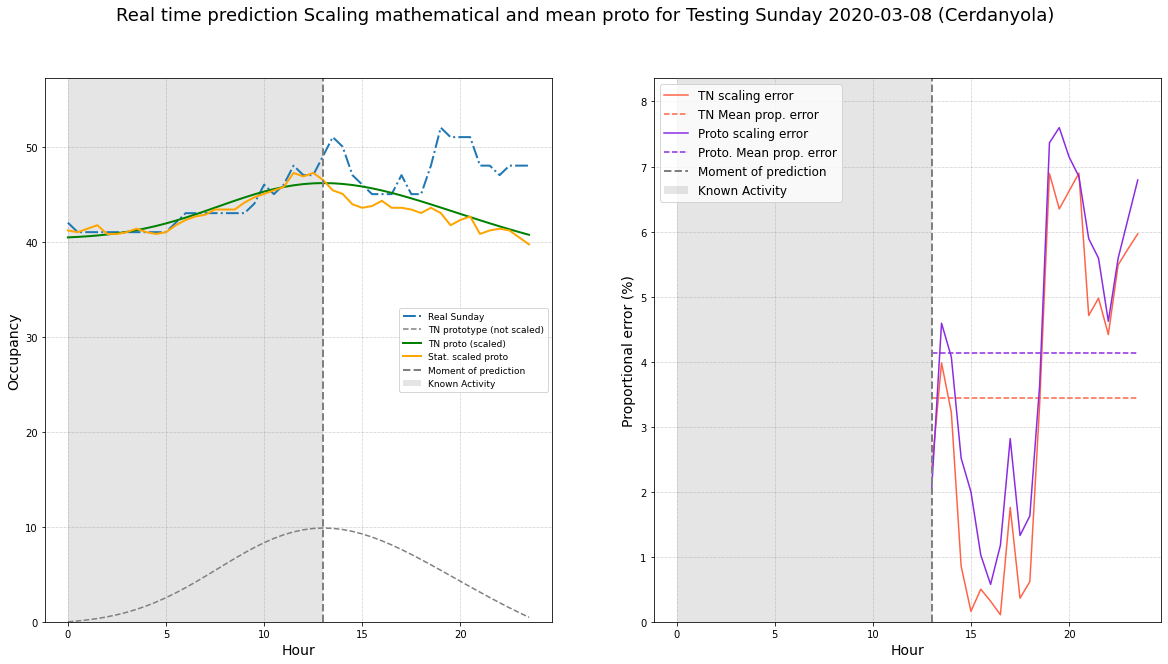

In [71]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

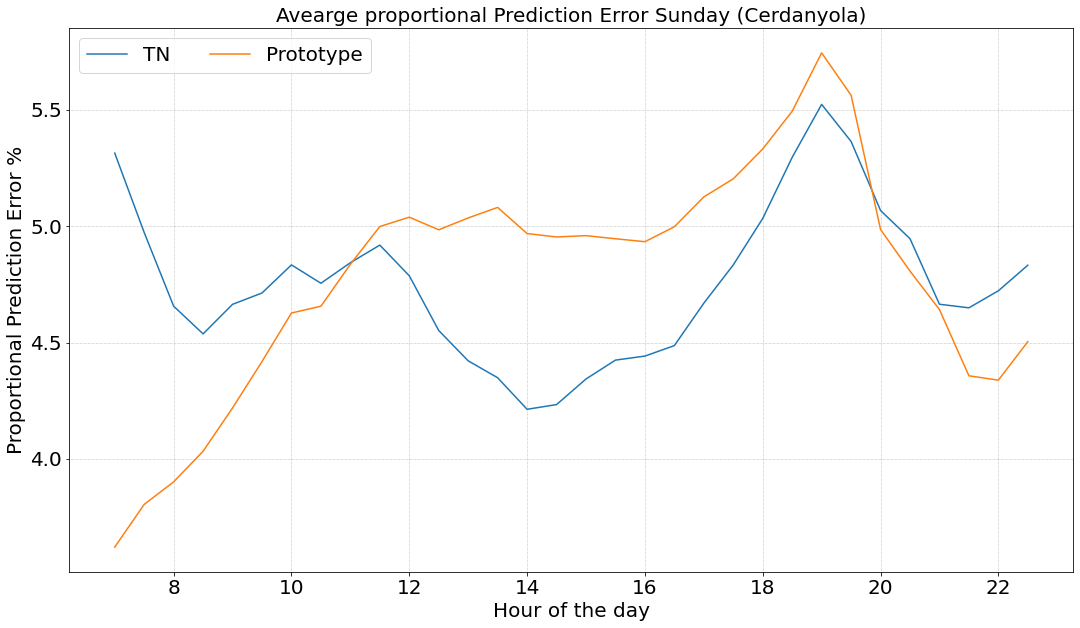

In [72]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [73]:
proto_running_error_we=np.concatenate((proto_running_error_we, proto_running_error_vec), axis=1)
tn_running_error_we=np.concatenate((tn_running_error_we, tn_running_error_vec), axis=1)

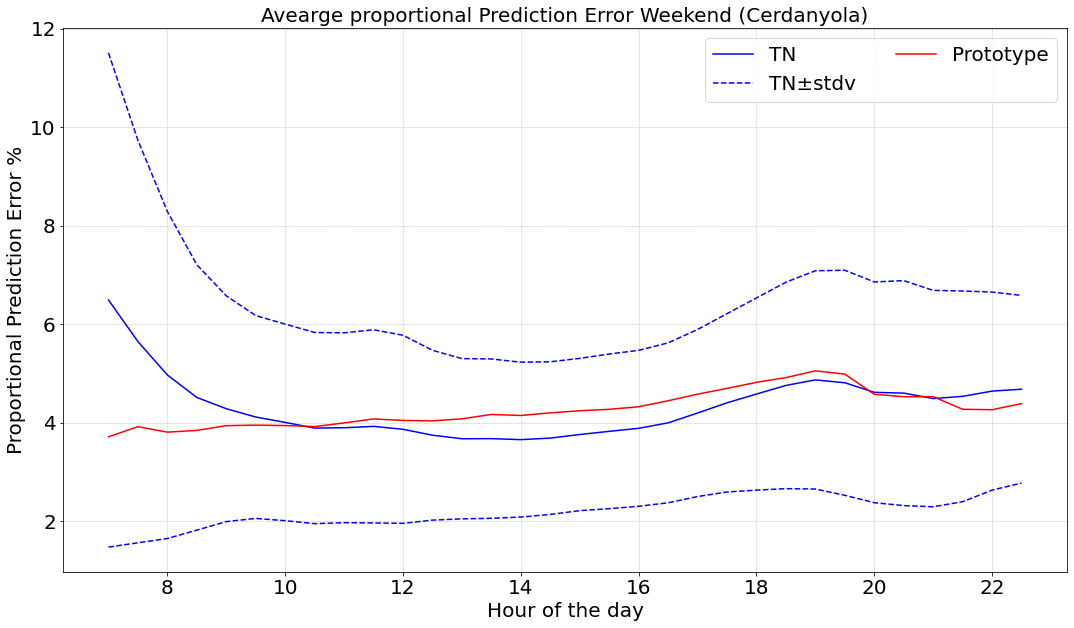

In [74]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_we,proto_running_error_we,starting_hour,"Weekend",current_parking)

2020-02-23
Real Sunday scaled prototype error:  9.78 %
Real Sunday scaled prototype error (median):  9.52 %
Real Sunday scaled prototype STDV: 4.1300483560339485
Real Sunday scaled TN error:  5.54 %
Real Sunday scaled TN error (median):  4.49 %
Real Sunday scaled TN STDV:  3.755858976088038
_____________________________________________________________
2020-03-08
Real Sunday scaled prototype error:  9.1 %
Real Sunday scaled prototype error (median):  6.9 %
Real Sunday scaled prototype STDV: 4.980293780153025
Real Sunday scaled TN error:  5.31 %
Real Sunday scaled TN error (median):  3.27 %
Real Sunday scaled TN STDV:  4.36197115608684
_____________________________________________________________


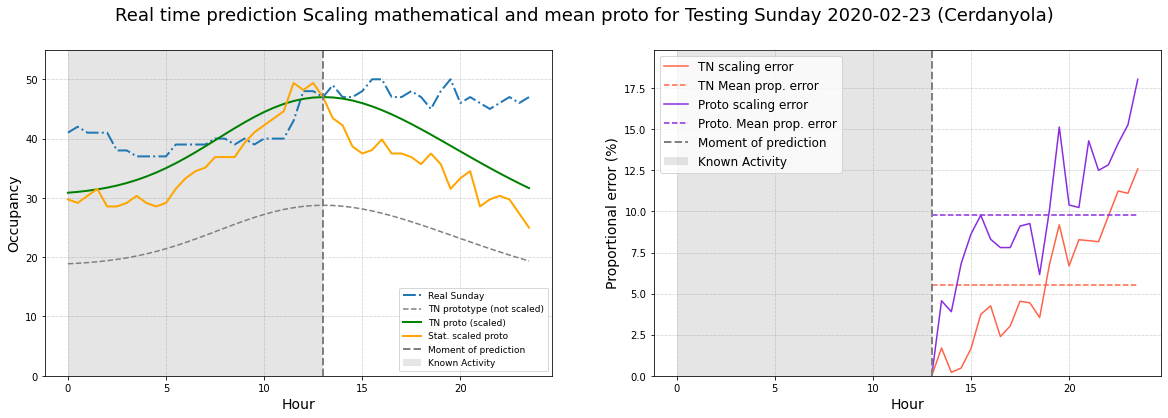

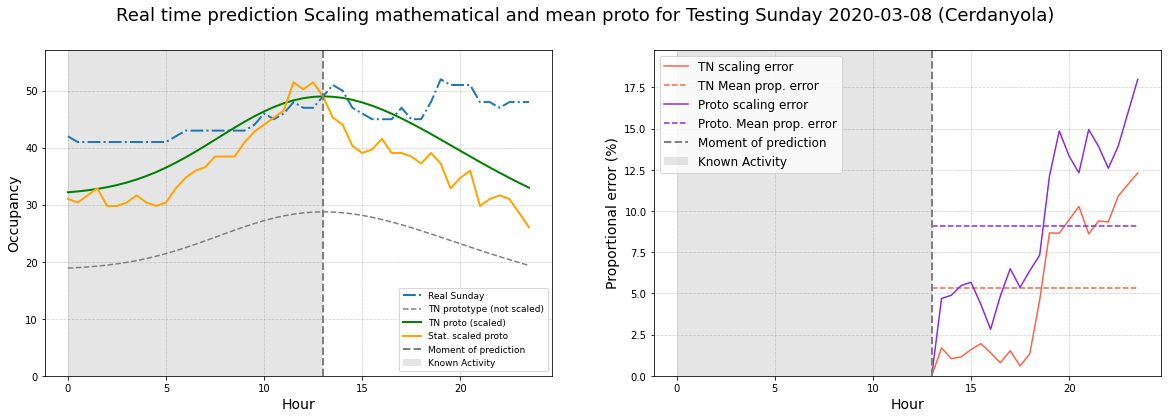

In [75]:
tn_proto = tn1_weekend
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

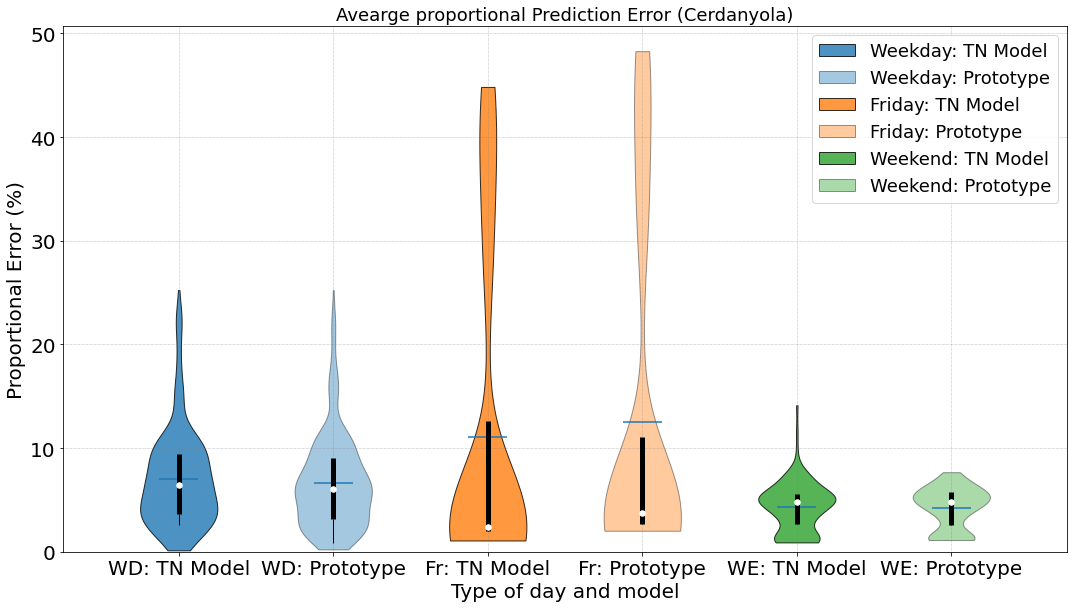

In [76]:
data = [tn_running_error_wd.flatten(),proto_running_error_wd.flatten(),
        tn_running_error_fr.flatten(),proto_running_error_fr.flatten(),
        tn_running_error_we.flatten(),proto_running_error_we.flatten()]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

ax2.set_title("Avearge proportional Prediction Error ("+ current_parking+')', fontsize=fsize)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%2==0:
        pc.set_facecolor('#D43F3A')
        pc.set_facecolor(color_vec[int((cc-2)/2)])
        pc.set_alpha(.4)
    else:
        pc.set_facecolor(color_vec[int((cc-1)/2)])
        pc.set_alpha(.8)
    pc.set_edgecolor('black')


quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wd.flatten(),proto_running_error_wd.flatten()], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_fr.flatten(),proto_running_error_fr.flatten()], [25, 50, 75], axis=1)
quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_we.flatten(),proto_running_error_we.flatten()], [25, 50, 75], axis=1)

quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['WD: TN Model', 'WD: Prototype','Fr: TN Model', 'Fr: Prototype','WE: TN Model', 'WE: Prototype']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)

ax2.legend(['Weekday: TN Model','Weekday: Prototype','Friday: TN Model','Friday: Prototype',
           'Weekend: TN Model','Weekend: Prototype'], fontsize=fsize)
#ax2.tick_params(axis='y', labelsize=20)
plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
fig.savefig('RunningPredictionError_'+current_parking+'_violin.pdf',bbox_inches='tight');

In [77]:
#figH=plotRunningPredcitionErrorAgg(tn_running_error_wd,proto_running_error_wd,tn_running_error_fr,
#                                  proto_running_error_fr,tn_running_error_we,proto_running_error_we,
#                                  starting_hour,current_parking,False)
#figH.savefig('RunningPredictionError_'+current_parking+'.pdf',bbox_inches='tight');


## Running  Prediction

In [78]:
day_indexes = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tn_proto_dict={}
tn_proto_dict["Monday"] = tn_weekday_nooff
tn_proto_dict["Tuesday"] = tn_weekday_nooff
tn_proto_dict["Wednesday"] = tn_weekday_nooff
tn_proto_dict["Thursday"] = tn_weekday_nooff
tn_proto_dict["Friday"] = tn_friday_nooff
tn_proto_dict["Saturday"] = tn1_weekend_nooff
tn_proto_dict["Sunday"] = tn1_weekend_nooff

t_days_dict={}
t_days_dict["Monday"] = testing_mondays
t_days_dict["Tuesday"] = testing_tuesdays
t_days_dict["Wednesday"] = testing_wednesdays
t_days_dict["Thursday"] = testing_thursdays
t_days_dict["Friday"] = testing_fridays
t_days_dict["Saturday"] = testing_saturdays
t_days_dict["Sunday"] = testing_sundays

hist_proto_dict={}
hist_proto_dict["Monday"] = hist_weekday_proto
hist_proto_dict["Tuesday"] = hist_weekday_proto
hist_proto_dict["Wednesday"] = hist_weekday_proto
hist_proto_dict["Thursday"] = hist_weekday_proto
hist_proto_dict["Friday"] = hist_friday_proto
hist_proto_dict["Saturday"] = hist_weekend_proto
hist_proto_dict["Sunday"] = hist_weekend_proto

#predWindow_vec=[0.5, 1, 1.5, 2, 2.5, 3] 
predWindow_vec=[1, 2, 3] 

pred_error_array=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])

proto_running_errorNOW_wd=[None] * len(predWindow_vec)
tn_running_errorNOW_wd=[None] *  len(predWindow_vec)
proto_running_errorNOW_fr=[None] * len(predWindow_vec)
tn_running_errorNOW_fr=[None] * len(predWindow_vec)
proto_running_errorNOW_we=[None] * len(predWindow_vec)
tn_running_errorNOW_we=[None] * len(predWindow_vec)


starting_hour=7
for i in range(0,len(day_indexes)):
    day=day_indexes[i]
    tn_proto=tn_proto_dict[day]
    t_days=t_days_dict[day]
    hist_proto=hist_proto_dict[day]
    j=0
    for pred_window in predWindow_vec:
        [tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNow(t_days,hist_proto,
                                                                                             tn_proto,max_value,starting_hour,pred_window)
        if day=='Monday':
            proto_running_errorNOW_wd[j]=proto_running_error_vec_now
            tn_running_errorNOW_wd[j]=tn_running_error_vec_now
        elif day in ['Tuesday','Wednesday','Thursday']:
            proto_running_errorNOW_wd[j]=np.concatenate((proto_running_errorNOW_wd[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_wd[j]=np.concatenate((tn_running_errorNOW_wd[j], tn_running_error_vec_now), axis=1)
        elif day == 'Friday':
            proto_running_errorNOW_fr[j]=proto_running_error_vec_now
            tn_running_errorNOW_fr[j]=tn_running_error_vec_now
        elif day == 'Saturday':
            proto_running_errorNOW_we[j]=proto_running_error_vec_now
            tn_running_errorNOW_we[j]=tn_running_error_vec_now
        else:
            proto_running_errorNOW_we[j]=np.concatenate((proto_running_errorNOW_we[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_we[j]=np.concatenate((tn_running_errorNOW_we[j], tn_running_error_vec_now), axis=1)
            
            
        pred_error_array[j,i]=np.mean(tn_running_error_vec_now)
        pred_error_array_proto[j,i]=np.mean(proto_running_error_vec_now)
        pred_error_array_stdv[j,i]=np.std(tn_running_error_vec_now)
        pred_error_array_proto_stdv[j,i]=np.std(tn_running_error_vec_now)
        
        j=j+1
        #plotRunningPredcitionError(tn_running_error_vec_now,proto_running_error_vec_now,starting_hour,day,current_parking)

In [79]:
tn_running_error_wd=tn_running_errorNOW_wd[0]
tn_running_error_fr=tn_running_errorNOW_fr[0]
tn_running_error_we=tn_running_errorNOW_we[0]
proto_running_error_wd=proto_running_errorNOW_wd[0]
proto_running_error_fr=proto_running_errorNOW_fr[0]
proto_running_error_we=proto_running_errorNOW_we[0]

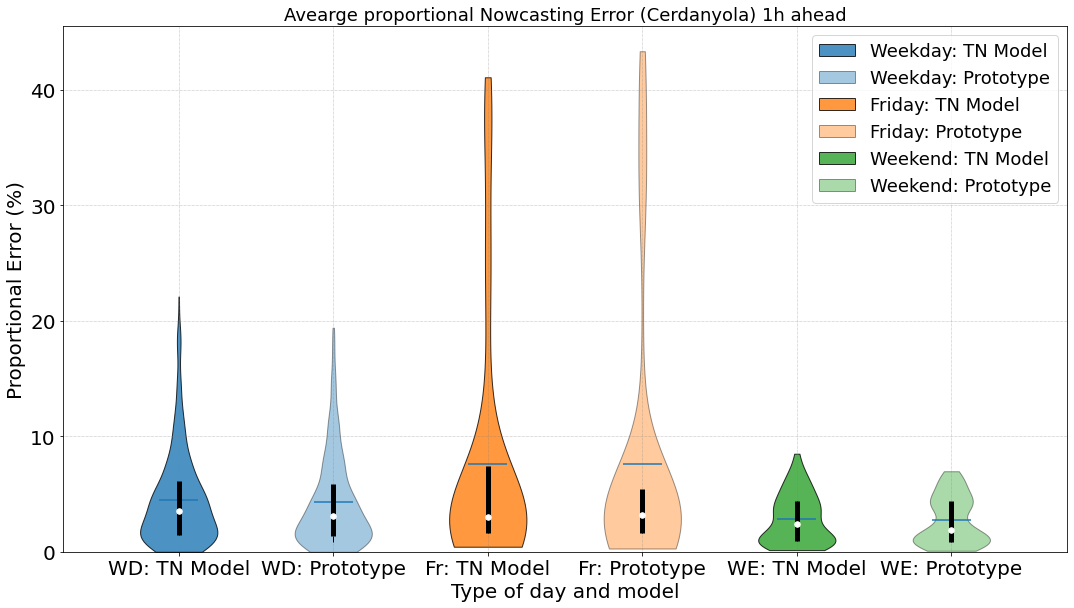

In [80]:
data = [tn_running_error_wd.flatten(),proto_running_error_wd.flatten(),
        tn_running_error_fr.flatten(),proto_running_error_fr.flatten(),
        tn_running_error_we.flatten(),proto_running_error_we.flatten()]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

ax2.set_title("Avearge proportional Nowcasting Error ("+ current_parking+') 1h ahead', fontsize=fsize)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%2==0:
        pc.set_facecolor('#D43F3A')
        pc.set_facecolor(color_vec[int((cc-2)/2)])
        pc.set_alpha(.4)
    else:
        pc.set_facecolor(color_vec[int((cc-1)/2)])
        pc.set_alpha(.8)
    pc.set_edgecolor('black')


quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wd.flatten(),proto_running_error_wd.flatten()], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_fr.flatten(),proto_running_error_fr.flatten()], [25, 50, 75], axis=1)
quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_we.flatten(),proto_running_error_we.flatten()], [25, 50, 75], axis=1)

quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['WD: TN Model', 'WD: Prototype','Fr: TN Model', 'Fr: Prototype','WE: TN Model', 'WE: Prototype']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)

ax2.legend(['Weekday: TN Model','Weekday: Prototype','Friday: TN Model','Friday: Prototype',
           'Weekend: TN Model','Weekend: Prototype'], fontsize=fsize)
#ax2.tick_params(axis='y', labelsize=20)
plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
fig.savefig('RunningPredictionError_'+current_parking+'_violin_NOW1h.pdf',bbox_inches='tight');

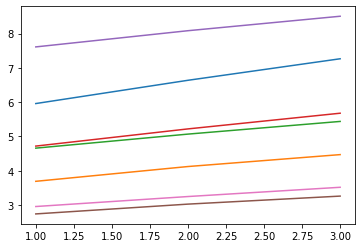

In [81]:
plt.plot(predWindow_vec,pred_error_array)


In [82]:
#plt.plot(predWindow_vec,pred_error_array_proto)

In [83]:
m_row_runPred=[current_parking,'meanE_tn'] + pred_error_array[0,].tolist()
s_row_runPred=[current_parking,'mStdvE_tn'] + pred_error_array_stdv[0,].tolist()
m_row_runPred_proto=[current_parking,'meanE_proto'] + pred_error_array_proto[0,].tolist()
s_row_runPred_proto=[current_parking,'mStdvE_proto'] + pred_error_array_proto_stdv[0,].tolist()



In [84]:
f = open('data/'+current_parking+'_runnError_1h.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row_runPred)
writer.writerow(s_row_runPred)
writer.writerow(m_row_runPred_proto)
writer.writerow(s_row_runPred_proto)

# close the file
f.close()